# Preparation

In [1]:
!pip install torch
!pip install torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt
import random
import os
import enum
import numpy as np
import pandas as pd

C:\Users\karub\Anaconda3\envs\pytorch\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\karub\Anaconda3\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\karub\Anaconda3\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Create dataset

In [3]:
class QuestionType(enum.Enum):
    WHICH_ONE = 'which_one'
    IS_IN = 'is_in'
class DataSet(enum.Enum):
    MNIST = 'mnist'
    CIFAR10 = 'cifar10'
    CIFAR100 = 'cifar100'

get_question_type = {QuestionType.WHICH_ONE: 'Which_one',
                       QuestionType.IS_IN: 'Is_in'}
get_dataset_name = {DataSet.CIFAR10: 'Cifar10'}

In [4]:
get_dataset_name[DataSet.CIFAR10]

'Cifar10'

In [5]:
def generate_cifar10_dataloader(batch_size: int) -> [DataLoader, DataLoader, DataLoader, DataLoader]:
    train_transform = T.Compose(
        [T.ToTensor(), # transforms.RandomHorizontalFlip(), transforms.RandomCrop(32,4),
         T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    test_transform = T.Compose(
        [T.ToTensor(),
         T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    full_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset.data), shuffle=False, num_workers=0)
    return full_train_loader, train_loader, test_loader
full_train_loader, train_loader, test_loader = generate_cifar10_dataloader(256)
datas, labels = next(iter(full_train_loader))

Files already downloaded and verified


In [6]:
def generate_Q_A_label(single_class_assigned: int, 
                         question_type: int, 
                         all_class_size: int, 
                         question_class_size: int) -> list:
    
    all_class_set = range(all_class_size)
    question_class_set = random.sample(all_class_set, question_class_size)
    temporary_label_list = [0 for i in range(all_class_size)]
    
    if question_type == QuestionType.WHICH_ONE:
        if single_class_assigned in question_class_set:
            for i in [single_class_assigned]:
                temporary_label_list[i] = 1
        
        else:
            comp_question_class_set = [i for i in all_class_set if i not in question_class_set]
            for i in comp_question_class_set:
                temporary_label_list[i] = 1
        
    elif question_type == QuestionType.IS_IN:
        if single_class_assigned in question_class_set:
            for i in question_class_set:
                temporary_label_list[i] = 1
        
        else:
            comp_question_class_set = [i for i in all_class_set if i not in question_class_set]
            for i in comp_question_class_set:
                temporary_label_list[i] = 1
    
    return temporary_label_list

temporary_label_list = generate_Q_A_label(single_class_assigned=6, 
                                            question_type=QuestionType.WHICH_ONE, 
                                            all_class_size=10, 
                                            question_class_size=9)

temporary_label_list

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [7]:
def generate_Q_A_labels(labels_tensor: torch.tensor, 
                          question_type: QuestionType,
                          all_class_size: int,
                          question_class_size: int) -> torch.tensor:
    
    labels_list = labels_tensor.tolist()
    Q_A_labels_list = []
    
    for label in labels_list:
        Q_A_label = generate_Q_A_label(single_class_assigned=label, 
                                          question_type=question_type,  # change out of this function
                                          all_class_size=all_class_size, # change out of this function
                                          question_class_size=question_class_size) # change out of this function
        Q_A_labels_list.append(Q_A_label)
        
    Q_A_labels_tensor = torch.tensor(Q_A_labels_list)
    
    return Q_A_labels_tensor

In [8]:
def generate_cifar10_dataloader_with_Q_A_label(full_train_loader: DataLoader, 
                                                  question_type: QuestionType,
                                                  question_size: int,
                                                  batch_size: int) ->[DataLoader, int, int]:
    
    for i, (datas, labels) in enumerate(full_train_loader):
        all_class_size = torch.max(labels) + 1 # K is number of classes, full_train_loader is full batch
        
    Q_A_labels_tensor = generate_Q_A_labels(labels, question_type, all_class_size, question_size)
    Q_A_labels_matrix_dataset = torch.utils.data.TensorDataset(datas, Q_A_labels_tensor.float())
    Q_A_labels_matrix_train_loader = torch.utils.data.DataLoader(dataset=Q_A_labels_matrix_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    dimension = int(datas.reshape(-1).shape[0]/datas.shape[0])
    return Q_A_labels_matrix_train_loader, dimension, all_class_size.tolist()

Q_A_labels_matrix_train_loader, dimension, all_class_size = generate_cifar10_dataloader_with_Q_A_label(full_train_loader, 
                                                                                                           QuestionType.WHICH_ONE,
                                                                                                           question_size=1,
                                                                                                           batch_size=256)
Q_A_datas, Q_A_labels = next(iter(Q_A_labels_matrix_train_loader))
print(Q_A_datas)
print(Q_A_labels)
print(dimension)
print(all_class_size)

tensor([[[[ 0.7890,  0.0428, -0.2113,  ..., -1.5290, -1.4814, -1.3862],
          [ 0.5349, -0.0208, -0.4177,  ..., -0.6876, -0.9416, -1.1480],
          [ 0.2809,  0.0904, -0.1954,  ..., -0.1636, -0.1636, -0.3383],
          ...,
          [ 0.3920,  0.4556,  0.3920,  ..., -0.1478,  0.0110,  0.0586],
          [ 0.3762,  0.3762,  0.3603,  ...,  0.2650,  0.1539,  0.1380],
          [ 0.4714,  0.3285,  0.4556,  ...,  0.1698,  0.1221,  0.1539]],

         [[ 0.4686, -0.2253, -0.3867,  ..., -1.5325, -1.4841, -1.2259],
          [ 0.1459, -0.3383, -0.6449,  ..., -0.6933, -1.1129, -1.2743],
          [-0.0155, -0.2737, -0.4512,  ..., -0.1285, -0.1285, -0.4028],
          ...,
          [ 0.2266,  0.1943,  0.1297,  ..., -0.3544, -0.2576, -0.2253],
          [ 0.1781,  0.1459,  0.1297,  ..., -0.0316, -0.0962, -0.0801],
          [ 0.2427,  0.1620,  0.2911,  ..., -0.1608, -0.1285, -0.0478]],

         [[ 0.2726, -0.4035, -0.5838,  ..., -1.3201, -1.4102, -1.1097],
          [-0.0129, -0.4937, -

In [9]:
from traitlets.traitlets import Integer
# Unclear!!!
DataSet_2_DataLoader_generator = {
    #DataSet.MNIST: generate_mnist_dataloader,
    DataSet.CIFAR10: generate_cifar10_dataloader,
    #DataSet.CIFAR100: generate_cifar100_dataloader,
}
DataSet_2_DataLoader_generator_with_Q_A_label = {
    #DataSet.MNIST: generate_mnist_dataloader,
    DataSet.CIFAR10: generate_cifar10_dataloader_with_Q_A_label,
    #DataSet.CIFAR100: generate_cifar100_dataloader,
}

def DataSet_2_DataLoader_with_Q_A_label(dataset: DataSet,
                                             question_type: QuestionType,
                                             question_size: int,
                                             batch_size: int
                                             ) -> [DataLoader, DataLoader, DataLoader, int, Integer]:
    
    dataloader_generator = DataSet_2_DataLoader_generator[dataset]
    full_train_loader, train_loader, test_loader = dataloader_generator(batch_size)
    dataloader_generator_with_Q_A_label = DataSet_2_DataLoader_generator_with_Q_A_label[dataset]
    Q_A_labels_matrix_train_loader, dimension, all_class_size = dataloader_generator_with_Q_A_label(full_train_loader, question_type, question_size, batch_size)
    
    return Q_A_labels_matrix_train_loader, train_loader, test_loader, dimension, all_class_size

DataSet_2_DataLoader_with_Q_A_label(DataSet.CIFAR10, QuestionType.WHICH_ONE, 9, 256)

Files already downloaded and verified


(<torch.utils.data.dataloader.DataLoader at 0x1c0e3bc8280>,
 3072,
 10)

# Model excution

In [10]:
import torch.nn as nn
import torch
import math
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def mae_loss(outputs, labels):
    sm_outputs = F.softmax(outputs, dim=1)
    loss_fn = nn.L1Loss(reduction='none')
    loss_matrix = loss_fn(sm_outputs, labels.float())
    sample_loss = loss_matrix.sum(dim=-1)
    return sample_loss
    
def mse_loss(outputs, labels):
    sm_outputs = F.softmax(outputs, dim=1)
    loss_fn = nn.MSELoss(reduction='none')
    loss_matrix = loss_fn(sm_outputs, labels.float())
    sample_loss = loss_matrix.sum(dim=-1)
    return sample_loss

def gce_loss(outputs, labels):
    q = 0.7
    sm_outputs = F.softmax(outputs, dim=1)
    pow_outputs = torch.pow(sm_outputs, q)
    sample_loss = (1-(pow_outputs*labels).sum(dim=1))/q # n
    return sample_loss

def phuber_ce_loss(outputs, labels):
    trunc_point = 0.1
    n = labels.shape[0]
    soft_max = nn.Softmax(dim=1)
    sm_outputs = soft_max(outputs)
    final_outputs = sm_outputs * labels
    final_confidence = final_outputs.sum(dim=1)
   
    ce_index = (final_confidence > trunc_point)
    sample_loss = torch.zeros(n).to(device)

    if ce_index.sum() > 0:
        ce_outputs = outputs[ce_index,:]
        logsm = nn.LogSoftmax(dim=-1)
        logsm_outputs = logsm(ce_outputs)
        final_ce_outputs = logsm_outputs * labels[ce_index,:]
        sample_loss[ce_index] = - final_ce_outputs.sum(dim=-1)

    linear_index = (final_confidence <= trunc_point)

    if linear_index.sum() > 0:
        sample_loss[linear_index] = -math.log(trunc_point) + (-1/trunc_point)*final_confidence[linear_index] + 1

    return sample_loss

def ce_loss(outputs, labels):
    logsm = nn.LogSoftmax(dim=1)
    logsm_outputs = logsm(outputs)
    final_outputs = logsm_outputs * labels
    sample_loss = - final_outputs.sum(dim=1)
    return sample_loss

def W_O_loss(loss_fn, outputs, labels, device, question_class_size, all_class_size):
    n, k = labels.shape[0], labels.shape[1]
    temp_loss = torch.zeros(n, k).to(device)
    for i in range(k):
        tempY = torch.zeros(n, k).to(device)
        tempY[:, i] = 1.0
        temp_loss[:, i] = loss_fn(outputs, tempY)
        
    candidate_loss = (temp_loss * labels).sum(dim=1)
    noncandidate_loss = (temp_loss * (1-labels)).sum(dim=1)
    total_loss = candidate_loss - noncandidate_loss * ((all_class_size - question_class_size) * (all_class_size - question_class_size - 1))/(question_class_size * (2*all_class_size - question_class_size - 1.0))
    average_loss = total_loss.mean()
    return average_loss

def I_I_loss(loss_fn, outputs, labels, device, question_class_size, all_class_size):
    n, k = labels.shape[0], labels.shape[1]
    temp_loss = torch.zeros(n, k).to(device)
    for i in range(k):
        tempY = torch.zeros(n, k).to(device)
        tempY[:, i] = 1.0
        temp_loss[:, i] = ce_loss(outputs, tempY)
        
    candidate_loss = (temp_loss * labels).sum(dim=1)
    noncandidate_loss = (temp_loss * (1-labels)).sum(dim=1)
    total_loss = candidate_loss - noncandidate_loss * (2*question_class_size**2 + all_class_size**2 - all_class_size*(2*question_class_size + 1))/(2*question_class_size * (all_class_size - question_class_size))
    average_loss = total_loss.mean()
    return average_loss


In [11]:
class mlp_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(mlp_model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = x.view(-1, self.num_flat_features(x))
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [12]:
def accuracy_check(loader, model, device):
    with torch.no_grad():
        total, num_samples = 0, 0
        for images, labels in loader:
            labels, images = labels.to(device), images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += (predicted == labels).sum().item()
            num_samples += labels.size(0) 
    return total / num_samples

In [13]:
def show_loss(epoch,max_epoch, loss):
  print('TRAIN EPOCH[{:03}/{:03}] LOSS:{:03f}'.format(epoch, max_epoch, loss))
def show_acc(epoch,max_epoch, acc, is_val):
  if is_val:
    print('TEST EPOCH[{:03}/{:03}] ACC:{:03f}%'.format(epoch, max_epoch, acc*100))
  else:
    print('TRAIN EPOCH[{:03}/{:03}] ACC:{:03f}%'.format(epoch, max_epoch, acc*100))

In [23]:
def Train(model, 
          question_type, 
          question_class_size, 
          all_class_size, 
          criterion, 
          optimizer, 
          data_loader, 
          device, 
          epoch, 
          max_epoch):
        
    total_loss_train = 0.0

    for n, (data, label) in enumerate(data_loader):
        
        model.train()
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        if question_type == QuestionType.WHICH_ONE:
            loss = W_O_loss(criterion, output, label.float(), device, question_class_size, all_class_size)
        elif question_type == QuestionType.IS_IN:
            loss = I_I_loss(criterion, output, label.float(), device, question_class_size, all_class_size)
        else:
            loss = criterion(output,label)

        loss.backward()
        optimizer.step()
        total_loss_train += loss.item()

    show_loss(epoch+1, max_epoch, total_loss_train/(n+1))
    print()
        #show_score(epoch+1, max_epoch, n+1, len(data_loader), total_acc_test/(n+1), is_val=True)
        #print()

    return total_loss_train/(n+1), model
        

In [24]:
def Eval(model, 
        evaluation_data_loader_train, 
        evaluation_data_loader_test, 
        device, 
        epoch, 
        max_epoch):
    model.eval()
    total_acc_train = accuracy_check(evaluation_data_loader_train, model, device)
    total_acc_test = accuracy_check(evaluation_data_loader_test, model, device)


    show_acc(epoch+1, max_epoch, total_acc_train, is_val=False)
    print()
    show_acc(epoch+1, max_epoch, total_acc_test, is_val=True)
    print()
        
    return total_acc_train , total_acc_test, model
        

In [16]:
get_model = {mlp_model: 'MLP'}
get_loss_function = {ce_loss: 'CE_LOSS', 
                     mae_loss: 'MAE_LOSS'}

In [290]:
Q_A_labels_matrix_train_loader, train_loader, test_loader, dimension, all_class_size = DataSet_2_DataLoader_with_Q_A_label(DataSet.CIFAR10, 
                                                                                                                                    QuestionType.WHICH_ONE, 
                                                                                                                                    5,
                                                                                                                                    256)
question_type = QuestionType.WHICH_ONE
criterion = ce_loss
question_class_size = 1
DEVICE= torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = mlp_model(input_dim=dimension, hidden_dim=500, output_dim=all_class_size).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

Files already downloaded and verified


In [302]:
for i in range(10):
  for n, (data, label) in enumerate(Q_A_labels_matrix_train_loader):
          
      model.train()
      optimizer.zero_grad()
      data = data.to(device)
      label = label.to(device)
      output = model(data)
      if question_type == QuestionType.WHICH_ONE:
          loss = W_O_loss(criterion, output, label.float(), device, question_class_size, all_class_size)
      elif question_type == QuestionType.IS_IN:
          loss = I_I_loss(criterion, output, label.float(), device, question_class_size, all_class_size)
      else:
          loss = criterion(output,label)

      loss.backward()
      optimizer.step()
      print(loss)
      break

tensor(-1.1007e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.1712e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.0437e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.0659e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.1355e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.2847e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.2098e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.0604e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.1766e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.1402e+08, device='cuda:0', grad_fn=<MeanBackward0>)


In [297]:
loss_fn = ce_loss
n, k = label.shape[0], label.shape[1]
temp_loss = torch.zeros(n, k).to(device)
for i in range(k):
    tempY = torch.zeros(n, k).to(device)
    tempY[:, i] = 1.0
    temp_loss[:, i] = loss_fn(output, tempY)
    
candidate_loss = (temp_loss * label).sum(dim=1)
noncandidate_loss = (temp_loss * (1-label)).sum(dim=1)
#total_loss = candidate_loss - noncandidate_loss * ((all_class_size - question_class_size) * (all_class_size - question_class_size - 1))/(question_class_size * (2*all_class_size - question_class_size - 1.0))
#average_loss = total_loss.mean()

In [293]:
((all_class_size - question_class_size) * (all_class_size - question_class_size - 1))/(question_class_size * (2*all_class_size - question_class_size - 1.0))

4.0

In [303]:
output

tensor([[-2429489.5000, -2426814.5000, -2426030.0000,  ...,
         -2424105.7500, -2424784.0000, -2431886.5000],
        [ -190720.4531,  -191581.9844,  -191569.8750,  ...,
          -191624.5156,  -190311.1406,   193819.3438],
        [-2115964.0000, -2125876.7500, -2125278.7500,  ...,
         -2124501.7500, -2113784.0000,  2146404.5000],
        ...,
        [-1256816.5000, -1262651.1250, -1262364.2500,  ...,
         -1262069.5000, -1255251.5000,  1275383.5000],
        [-4920971.5000, -4943879.0000, -4942682.5000,  ...,
         -4941531.0000, -4914790.0000,  4993593.5000],
        [-4193502.7500, -4188878.5000, -4187531.5000,  ...,
         -4184210.0000, -4185371.5000, -4197651.0000]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [286]:
candidate_loss

tensor([ 2.7035,  2.1264, 11.7909, 11.8447, 12.0772, 11.1616,  2.4152, 12.2189,
         2.2627,  2.2503, 11.5923,  2.2620, 12.0367,  1.9462, 11.6392,  2.4659,
        11.8665,  2.3845, 12.2162, 11.8105,  2.0721, 11.7571,  1.9975, 11.3322,
         2.4226, 11.6394, 11.3531, 11.2059,  2.0641, 11.4463,  2.5458, 11.5087,
        11.2925, 12.4827, 10.8914, 12.0088,  2.3541, 11.3807, 11.3973, 12.3914,
        12.0847, 11.7740, 12.4540, 11.8519,  2.4959,  2.1728,  2.4215, 11.9946,
        10.9585, 11.3056, 11.8556, 12.1028,  2.4239,  2.1613,  2.5560,  2.0743,
         2.2869,  2.4637,  2.4129, 11.5247,  2.3023, 11.6739, 11.1830, 11.5310,
         2.2617,  2.1468, 11.5778,  2.2051,  2.4198,  2.3749,  2.3639, 11.5619,
         2.5727, 11.7691,  2.3621,  2.2211, 11.8497, 11.4155,  2.4728,  2.4127,
        11.6315,  2.1799,  2.2129,  2.3135, 11.6611, 11.5611, 11.2746, 11.4583,
        11.5915, 11.5182,  2.4043,  2.2888, 11.9801, 11.8816,  2.4012, 11.5363,
         1.9800, 11.6282, 11.8807, 11.32

In [284]:
logsm = nn.LogSoftmax(dim=1)
logsm_outputs = logsm(output)
final_outputs = logsm_outputs * label
#sample_loss = - final_outputs.sum(dim=1)

In [281]:
logsm_outputs[0]

tensor([-2.1803, -2.0077, -2.5094, -2.5926, -1.7819, -2.0641, -2.4855, -2.4026,
        -2.8038, -2.7035], device='cuda:0', grad_fn=<SelectBackward0>)

In [282]:
output[0]

tensor([ 0.1369,  0.3095, -0.1922, -0.2754,  0.5353,  0.2531, -0.1683, -0.0854,
        -0.4866, -0.3863], device='cuda:0', grad_fn=<SelectBackward0>)

In [285]:
final_outputs

tensor([[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -2.7035],
        [-0.0000, -2.1264, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-2.1761, -0.0000, -2.6121,  ..., -2.1944, -0.0000, -2.2690],
        ...,
        [-2.0478, -0.0000, -0.0000,  ..., -2.1241, -0.0000, -0.0000],
        [-0.0000, -2.0643, -2.3092,  ..., -2.2365, -0.0000, -0.0000],
        [-0.0000, -0.0000, -2.2716,  ..., -0.0000, -2.4108, -2.3941]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [251]:
label[1]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

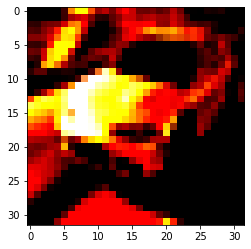

In [252]:
i=data[1].to("cpu")
plt.imshow(i.permute(1,2,0))

In [242]:
i

tensor([[[-0.2589, -0.9838, -0.7942],
         [-0.4335, -1.0806, -0.8543],
         [-0.4018, -0.7901, -0.5087],
         ...,
         [ 2.0274,  2.0986,  2.0906],
         [ 2.0274,  2.0986,  2.0906],
         [ 2.0274,  2.0986,  2.0906]],

        [[-0.2589, -0.9838, -0.7942],
         [-0.4653, -1.0806, -0.8693],
         [-0.4335, -0.7901, -0.5388],
         ...,
         [ 2.0591,  2.1309,  2.1207],
         [ 2.0591,  2.1309,  2.1207],
         [ 2.0591,  2.1309,  2.1207]],

        [[-0.3065, -0.9999, -0.8092],
         [-0.5923, -1.1290, -0.9144],
         [-0.5606, -0.8547, -0.6439],
         ...,
         [ 2.0432,  2.1147,  2.1057],
         [ 2.0432,  2.1147,  2.1057],
         [ 2.0432,  2.1147,  2.1057]],

        ...,

        [[-0.8305, -1.1775, -0.9745],
         [-0.8781, -1.0483, -0.8994],
         [-1.2115, -1.1775, -1.0196],
         ...,
         [-0.8781, -0.6126, -0.3284],
         [-0.9257, -0.6772, -0.3885],
         [-0.9416, -0.7094, -0.4035]],

        [[

In [19]:
from tqdm.notebook import tqdm

In [25]:
def Q_A_label_Train_Eval(dataset, 
                          question_type, 
                          question_class_size, 
                          model_name, 
                          batch_size, 
                          loss_fn, 
                          EPOCHS):
    Q_A_labels_matrix_train_loader, train_loader, test_loader, dimension, all_class_size = DataSet_2_DataLoader_with_Q_A_label(dataset, 
                                                                                                                                    question_type, 
                                                                                                                                    question_class_size,
                                                                                                                                    batch_size)
    DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model = model_name(input_dim=dimension, hidden_dim=500, output_dim=all_class_size).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []
    #criterion=nn.CrossEntropyLoss()
    result_df = pd.DataFrame(columns=["dataset", "epoch", "question_type", "question_class_size", "model", "loss_function", "train_loss", "train_acc", "test_acc"])

    for epoch in tqdm(range(EPOCHS)):
        train_loss, model = Train(model=model, 
                          question_type=question_type,
                          question_class_size=question_class_size,
                          all_class_size=all_class_size,
                          criterion=loss_fn,
                          optimizer=optimizer, 
                          data_loader=Q_A_labels_matrix_train_loader,
                          device=DEVICE, 
                          epoch=epoch, 
                          max_epoch=EPOCHS)
        
        train_acc, test_acc, model = Eval(model=model, 
                                    evaluation_data_loader_train=train_loader, 
                                    evaluation_data_loader_test=test_loader, 
                                    device=DEVICE, 
                                    epoch=epoch, 
                                    max_epoch=EPOCHS)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        #print(f'TRAIN EPOCH[{epoch+1}/{EPOCHS}] LOSS: {np.mean(train_loss_list)} ACC: {np.mean(train_acc_list)}')
        #print(f'TEST EPOCH[{epoch+1}/{EPOCHS}] ACC:{np.mean(test_acc_list)}')

        result_df = result_df.append({'dataset': get_dataset_name[dataset],
                                      'epoch': epoch+1,
                                      'question_type': get_question_type[question_type], 
                                      'question_class_size': question_class_size, 
                                      'model': get_model[model_name],
                                      'loss_function': get_loss_function[loss_fn],
                                      'train_loss': train_loss,
                                      'train_acc': train_acc,
                                      'test_acc': test_acc}, ignore_index=True)
        
    return result_df

In [29]:
for j in tqdm([QuestionType.WHICH_ONE, QuestionType.IS_IN]):
    for i in tqdm(range(1, 10)):
        if (j == QuestionType.WHICH_ONE) and (i == 1):
            results_df = Q_A_label_Train_Eval(dataset=DataSet.CIFAR10, 
                                                question_type=j, 
                                                question_class_size=i, 
                                                model_name=mlp_model, 
                                                batch_size=512, 
                                                loss_fn=mae_loss, 
                                                EPOCHS=300)
        else:
            result_df = Q_A_label_Train_Eval(dataset=DataSet.CIFAR10, 
                                                question_type=j, 
                                                question_class_size=i, 
                                                model_name=mlp_model, 
                                                batch_size=512, 
                                                loss_fn=mae_loss, 
                                                EPOCHS=300)
            results_df = pd.concat([results_df, result_df])

Files already downloaded and verified


TRAIN EPOCH[001/300] LOSS:1.699872

TRAIN EPOCH[001/300] ACC:22.580000%

TEST EPOCH[001/300] ACC:22.410000%

TRAIN EPOCH[002/300] LOSS:1.616238

TRAIN EPOCH[002/300] ACC:26.266000%

TEST EPOCH[002/300] ACC:26.110000%

TRAIN EPOCH[003/300] LOSS:1.584903

TRAIN EPOCH[003/300] ACC:25.266000%

TEST EPOCH[003/300] ACC:25.270000%

TRAIN EPOCH[004/300] LOSS:1.536979

TRAIN EPOCH[004/300] ACC:26.310000%

TEST EPOCH[004/300] ACC:25.890000%

TRAIN EPOCH[005/300] LOSS:1.500568

TRAIN EPOCH[005/300] ACC:28.586000%

TEST EPOCH[005/300] ACC:28.750000%

TRAIN EPOCH[006/300] LOSS:1.475064

TRAIN EPOCH[006/300] ACC:27.684000%

TEST EPOCH[006/300] ACC:27.580000%

TRAIN EPOCH[007/300] LOSS:1.477772

TRAIN EPOCH[007/300] ACC:30.168000%

TEST EPOCH[007/300] ACC:30.220000%

TRAIN EPOCH[008/300] LOSS:1.452899

TRAIN EPOCH[008/300] ACC:28.506000%

TEST EPOCH[008/300] ACC:28.450000%

TRAIN EPOCH[009/300] LOSS:1.489391

TRAIN EPOCH[009/300] ACC:28.510000%

TEST EPOCH[009/300] ACC:28.680000%

TRAIN EPOCH[010/300

TRAIN EPOCH[076/300] ACC:31.728000%

TEST EPOCH[076/300] ACC:31.440000%

TRAIN EPOCH[077/300] LOSS:1.439826

TRAIN EPOCH[077/300] ACC:27.610000%

TEST EPOCH[077/300] ACC:28.540000%

TRAIN EPOCH[078/300] LOSS:1.451097

TRAIN EPOCH[078/300] ACC:30.390000%

TEST EPOCH[078/300] ACC:30.640000%

TRAIN EPOCH[079/300] LOSS:1.396002

TRAIN EPOCH[079/300] ACC:31.270000%

TEST EPOCH[079/300] ACC:30.740000%

TRAIN EPOCH[080/300] LOSS:1.363536

TRAIN EPOCH[080/300] ACC:32.916000%

TEST EPOCH[080/300] ACC:32.430000%

TRAIN EPOCH[081/300] LOSS:1.360448

TRAIN EPOCH[081/300] ACC:31.154000%

TEST EPOCH[081/300] ACC:30.880000%

TRAIN EPOCH[082/300] LOSS:1.344577

TRAIN EPOCH[082/300] ACC:30.654000%

TEST EPOCH[082/300] ACC:30.760000%

TRAIN EPOCH[083/300] LOSS:1.377468

TRAIN EPOCH[083/300] ACC:30.324000%

TEST EPOCH[083/300] ACC:30.200000%

TRAIN EPOCH[084/300] LOSS:1.428716

TRAIN EPOCH[084/300] ACC:26.762000%

TEST EPOCH[084/300] ACC:26.140000%

TRAIN EPOCH[085/300] LOSS:1.368407

TRAIN EPOCH[085/300

TRAIN EPOCH[152/300] LOSS:1.259835

TRAIN EPOCH[152/300] ACC:32.784000%

TEST EPOCH[152/300] ACC:32.550000%

TRAIN EPOCH[153/300] LOSS:1.272332

TRAIN EPOCH[153/300] ACC:33.926000%

TEST EPOCH[153/300] ACC:32.960000%

TRAIN EPOCH[154/300] LOSS:1.272906

TRAIN EPOCH[154/300] ACC:32.296000%

TEST EPOCH[154/300] ACC:32.050000%

TRAIN EPOCH[155/300] LOSS:1.306126

TRAIN EPOCH[155/300] ACC:33.520000%

TEST EPOCH[155/300] ACC:32.990000%

TRAIN EPOCH[156/300] LOSS:1.288964

TRAIN EPOCH[156/300] ACC:33.782000%

TEST EPOCH[156/300] ACC:33.340000%

TRAIN EPOCH[157/300] LOSS:1.292336

TRAIN EPOCH[157/300] ACC:34.260000%

TEST EPOCH[157/300] ACC:33.720000%

TRAIN EPOCH[158/300] LOSS:1.287311

TRAIN EPOCH[158/300] ACC:34.068000%

TEST EPOCH[158/300] ACC:33.330000%

TRAIN EPOCH[159/300] LOSS:1.267344

TRAIN EPOCH[159/300] ACC:34.742000%

TEST EPOCH[159/300] ACC:34.660000%

TRAIN EPOCH[160/300] LOSS:1.267706

TRAIN EPOCH[160/300] ACC:33.460000%

TEST EPOCH[160/300] ACC:32.630000%

TRAIN EPOCH[161/300

TRAIN EPOCH[227/300] ACC:33.268000%

TEST EPOCH[227/300] ACC:33.160000%

TRAIN EPOCH[228/300] LOSS:1.202498

TRAIN EPOCH[228/300] ACC:34.736000%

TEST EPOCH[228/300] ACC:34.750000%

TRAIN EPOCH[229/300] LOSS:1.199690

TRAIN EPOCH[229/300] ACC:34.594000%

TEST EPOCH[229/300] ACC:34.480000%

TRAIN EPOCH[230/300] LOSS:1.179387

TRAIN EPOCH[230/300] ACC:36.356000%

TEST EPOCH[230/300] ACC:36.300000%

TRAIN EPOCH[231/300] LOSS:1.162780

TRAIN EPOCH[231/300] ACC:35.978000%

TEST EPOCH[231/300] ACC:36.200000%

TRAIN EPOCH[232/300] LOSS:1.188685

TRAIN EPOCH[232/300] ACC:34.810000%

TEST EPOCH[232/300] ACC:34.340000%

TRAIN EPOCH[233/300] LOSS:1.194077

TRAIN EPOCH[233/300] ACC:35.348000%

TEST EPOCH[233/300] ACC:35.400000%

TRAIN EPOCH[234/300] LOSS:1.230703

TRAIN EPOCH[234/300] ACC:33.960000%

TEST EPOCH[234/300] ACC:33.430000%

TRAIN EPOCH[235/300] LOSS:1.207925

TRAIN EPOCH[235/300] ACC:34.654000%

TEST EPOCH[235/300] ACC:34.540000%

TRAIN EPOCH[236/300] LOSS:1.261165

TRAIN EPOCH[236/300

TRAIN EPOCH[001/300] LOSS:1.486839

TRAIN EPOCH[001/300] ACC:30.320000%

TEST EPOCH[001/300] ACC:30.590000%

TRAIN EPOCH[002/300] LOSS:1.343518

TRAIN EPOCH[002/300] ACC:32.964000%

TEST EPOCH[002/300] ACC:32.960000%

TRAIN EPOCH[003/300] LOSS:1.317921

TRAIN EPOCH[003/300] ACC:32.076000%

TEST EPOCH[003/300] ACC:32.150000%

TRAIN EPOCH[004/300] LOSS:1.297867

TRAIN EPOCH[004/300] ACC:33.486000%

TEST EPOCH[004/300] ACC:33.810000%

TRAIN EPOCH[005/300] LOSS:1.280214

TRAIN EPOCH[005/300] ACC:35.026000%

TEST EPOCH[005/300] ACC:35.420000%

TRAIN EPOCH[006/300] LOSS:1.262224

TRAIN EPOCH[006/300] ACC:34.706000%

TEST EPOCH[006/300] ACC:35.090000%

TRAIN EPOCH[007/300] LOSS:1.259121

TRAIN EPOCH[007/300] ACC:34.648000%

TEST EPOCH[007/300] ACC:34.660000%

TRAIN EPOCH[008/300] LOSS:1.254894

TRAIN EPOCH[008/300] ACC:35.456000%

TEST EPOCH[008/300] ACC:35.590000%

TRAIN EPOCH[009/300] LOSS:1.214582

TRAIN EPOCH[009/300] ACC:36.708000%

TEST EPOCH[009/300] ACC:36.130000%

TRAIN EPOCH[010/300

TRAIN EPOCH[076/300] ACC:43.774000%

TEST EPOCH[076/300] ACC:41.350000%

TRAIN EPOCH[077/300] LOSS:0.927815

TRAIN EPOCH[077/300] ACC:44.580000%

TEST EPOCH[077/300] ACC:41.760000%

TRAIN EPOCH[078/300] LOSS:0.926891

TRAIN EPOCH[078/300] ACC:43.714000%

TEST EPOCH[078/300] ACC:41.100000%

TRAIN EPOCH[079/300] LOSS:0.929650

TRAIN EPOCH[079/300] ACC:44.450000%

TEST EPOCH[079/300] ACC:41.660000%

TRAIN EPOCH[080/300] LOSS:0.899128

TRAIN EPOCH[080/300] ACC:43.136000%

TEST EPOCH[080/300] ACC:40.480000%

TRAIN EPOCH[081/300] LOSS:0.899642

TRAIN EPOCH[081/300] ACC:44.548000%

TEST EPOCH[081/300] ACC:41.480000%

TRAIN EPOCH[082/300] LOSS:0.908326

TRAIN EPOCH[082/300] ACC:44.944000%

TEST EPOCH[082/300] ACC:42.570000%

TRAIN EPOCH[083/300] LOSS:0.901446

TRAIN EPOCH[083/300] ACC:43.618000%

TEST EPOCH[083/300] ACC:41.800000%

TRAIN EPOCH[084/300] LOSS:0.900868

TRAIN EPOCH[084/300] ACC:44.332000%

TEST EPOCH[084/300] ACC:41.790000%

TRAIN EPOCH[085/300] LOSS:0.885206

TRAIN EPOCH[085/300

TRAIN EPOCH[152/300] LOSS:0.725960

TRAIN EPOCH[152/300] ACC:46.696000%

TEST EPOCH[152/300] ACC:42.670000%

TRAIN EPOCH[153/300] LOSS:0.724984

TRAIN EPOCH[153/300] ACC:46.736000%

TEST EPOCH[153/300] ACC:42.790000%

TRAIN EPOCH[154/300] LOSS:0.716247

TRAIN EPOCH[154/300] ACC:47.580000%

TEST EPOCH[154/300] ACC:43.010000%

TRAIN EPOCH[155/300] LOSS:0.697910

TRAIN EPOCH[155/300] ACC:47.940000%

TEST EPOCH[155/300] ACC:42.990000%

TRAIN EPOCH[156/300] LOSS:0.693564

TRAIN EPOCH[156/300] ACC:47.170000%

TEST EPOCH[156/300] ACC:42.660000%

TRAIN EPOCH[157/300] LOSS:0.706739

TRAIN EPOCH[157/300] ACC:46.832000%

TEST EPOCH[157/300] ACC:42.210000%

TRAIN EPOCH[158/300] LOSS:0.690362

TRAIN EPOCH[158/300] ACC:47.028000%

TEST EPOCH[158/300] ACC:42.730000%

TRAIN EPOCH[159/300] LOSS:0.736823

TRAIN EPOCH[159/300] ACC:47.742000%

TEST EPOCH[159/300] ACC:43.680000%

TRAIN EPOCH[160/300] LOSS:0.691314

TRAIN EPOCH[160/300] ACC:46.542000%

TEST EPOCH[160/300] ACC:41.880000%

TRAIN EPOCH[161/300

TRAIN EPOCH[227/300] ACC:48.840000%

TEST EPOCH[227/300] ACC:43.270000%

TRAIN EPOCH[228/300] LOSS:0.593532

TRAIN EPOCH[228/300] ACC:48.876000%

TEST EPOCH[228/300] ACC:43.800000%

TRAIN EPOCH[229/300] LOSS:0.607630

TRAIN EPOCH[229/300] ACC:49.710000%

TEST EPOCH[229/300] ACC:43.720000%

TRAIN EPOCH[230/300] LOSS:0.582943

TRAIN EPOCH[230/300] ACC:49.338000%

TEST EPOCH[230/300] ACC:43.540000%

TRAIN EPOCH[231/300] LOSS:0.594405

TRAIN EPOCH[231/300] ACC:49.376000%

TEST EPOCH[231/300] ACC:43.460000%

TRAIN EPOCH[232/300] LOSS:0.595832

TRAIN EPOCH[232/300] ACC:48.468000%

TEST EPOCH[232/300] ACC:42.500000%

TRAIN EPOCH[233/300] LOSS:0.605034

TRAIN EPOCH[233/300] ACC:49.832000%

TEST EPOCH[233/300] ACC:44.090000%

TRAIN EPOCH[234/300] LOSS:0.583874

TRAIN EPOCH[234/300] ACC:49.578000%

TEST EPOCH[234/300] ACC:43.880000%

TRAIN EPOCH[235/300] LOSS:0.582268

TRAIN EPOCH[235/300] ACC:49.620000%

TEST EPOCH[235/300] ACC:43.750000%

TRAIN EPOCH[236/300] LOSS:0.597341

TRAIN EPOCH[236/300

TRAIN EPOCH[001/300] LOSS:1.359763

TRAIN EPOCH[001/300] ACC:32.244000%

TEST EPOCH[001/300] ACC:32.170000%

TRAIN EPOCH[002/300] LOSS:1.251880

TRAIN EPOCH[002/300] ACC:35.110000%

TEST EPOCH[002/300] ACC:35.520000%

TRAIN EPOCH[003/300] LOSS:1.189420

TRAIN EPOCH[003/300] ACC:36.140000%

TEST EPOCH[003/300] ACC:36.200000%

TRAIN EPOCH[004/300] LOSS:1.164318

TRAIN EPOCH[004/300] ACC:38.702000%

TEST EPOCH[004/300] ACC:37.760000%

TRAIN EPOCH[005/300] LOSS:1.143849

TRAIN EPOCH[005/300] ACC:39.216000%

TEST EPOCH[005/300] ACC:38.820000%

TRAIN EPOCH[006/300] LOSS:1.124017

TRAIN EPOCH[006/300] ACC:39.198000%

TEST EPOCH[006/300] ACC:38.890000%

TRAIN EPOCH[007/300] LOSS:1.107518

TRAIN EPOCH[007/300] ACC:39.858000%

TEST EPOCH[007/300] ACC:38.710000%

TRAIN EPOCH[008/300] LOSS:1.099674

TRAIN EPOCH[008/300] ACC:40.682000%

TEST EPOCH[008/300] ACC:39.870000%

TRAIN EPOCH[009/300] LOSS:1.071873

TRAIN EPOCH[009/300] ACC:41.864000%

TEST EPOCH[009/300] ACC:40.430000%

TRAIN EPOCH[010/300

TRAIN EPOCH[076/300] ACC:52.020000%

TEST EPOCH[076/300] ACC:45.850000%

TRAIN EPOCH[077/300] LOSS:0.646928

TRAIN EPOCH[077/300] ACC:53.386000%

TEST EPOCH[077/300] ACC:46.220000%

TRAIN EPOCH[078/300] LOSS:0.630044

TRAIN EPOCH[078/300] ACC:52.696000%

TEST EPOCH[078/300] ACC:46.200000%

TRAIN EPOCH[079/300] LOSS:0.649025

TRAIN EPOCH[079/300] ACC:50.354000%

TEST EPOCH[079/300] ACC:43.940000%

TRAIN EPOCH[080/300] LOSS:0.655413

TRAIN EPOCH[080/300] ACC:52.816000%

TEST EPOCH[080/300] ACC:46.140000%

TRAIN EPOCH[081/300] LOSS:0.627899

TRAIN EPOCH[081/300] ACC:52.630000%

TEST EPOCH[081/300] ACC:46.100000%

TRAIN EPOCH[082/300] LOSS:0.610202

TRAIN EPOCH[082/300] ACC:53.700000%

TEST EPOCH[082/300] ACC:46.890000%

TRAIN EPOCH[083/300] LOSS:0.615016

TRAIN EPOCH[083/300] ACC:52.856000%

TEST EPOCH[083/300] ACC:45.620000%

TRAIN EPOCH[084/300] LOSS:0.612035

TRAIN EPOCH[084/300] ACC:53.342000%

TEST EPOCH[084/300] ACC:45.970000%

TRAIN EPOCH[085/300] LOSS:0.602821

TRAIN EPOCH[085/300

TRAIN EPOCH[152/300] LOSS:0.478960

TRAIN EPOCH[152/300] ACC:56.702000%

TEST EPOCH[152/300] ACC:47.530000%

TRAIN EPOCH[153/300] LOSS:0.488604

TRAIN EPOCH[153/300] ACC:56.434000%

TEST EPOCH[153/300] ACC:46.710000%

TRAIN EPOCH[154/300] LOSS:0.468315

TRAIN EPOCH[154/300] ACC:57.228000%

TEST EPOCH[154/300] ACC:47.360000%

TRAIN EPOCH[155/300] LOSS:0.465776

TRAIN EPOCH[155/300] ACC:56.872000%

TEST EPOCH[155/300] ACC:47.030000%

TRAIN EPOCH[156/300] LOSS:0.478795

TRAIN EPOCH[156/300] ACC:56.442000%

TEST EPOCH[156/300] ACC:47.050000%

TRAIN EPOCH[157/300] LOSS:0.471439

TRAIN EPOCH[157/300] ACC:56.852000%

TEST EPOCH[157/300] ACC:47.320000%

TRAIN EPOCH[158/300] LOSS:0.464977

TRAIN EPOCH[158/300] ACC:56.888000%

TEST EPOCH[158/300] ACC:47.210000%

TRAIN EPOCH[159/300] LOSS:0.450299

TRAIN EPOCH[159/300] ACC:57.086000%

TEST EPOCH[159/300] ACC:47.130000%

TRAIN EPOCH[160/300] LOSS:0.443332

TRAIN EPOCH[160/300] ACC:57.164000%

TEST EPOCH[160/300] ACC:46.730000%

TRAIN EPOCH[161/300

TRAIN EPOCH[227/300] ACC:58.648000%

TEST EPOCH[227/300] ACC:47.690000%

TRAIN EPOCH[228/300] LOSS:0.412216

TRAIN EPOCH[228/300] ACC:56.430000%

TEST EPOCH[228/300] ACC:46.640000%

TRAIN EPOCH[229/300] LOSS:0.411591

TRAIN EPOCH[229/300] ACC:57.210000%

TEST EPOCH[229/300] ACC:47.100000%

TRAIN EPOCH[230/300] LOSS:0.432493

TRAIN EPOCH[230/300] ACC:57.848000%

TEST EPOCH[230/300] ACC:47.070000%

TRAIN EPOCH[231/300] LOSS:0.415807

TRAIN EPOCH[231/300] ACC:57.928000%

TEST EPOCH[231/300] ACC:47.480000%

TRAIN EPOCH[232/300] LOSS:0.422123

TRAIN EPOCH[232/300] ACC:56.858000%

TEST EPOCH[232/300] ACC:46.740000%

TRAIN EPOCH[233/300] LOSS:0.420204

TRAIN EPOCH[233/300] ACC:57.908000%

TEST EPOCH[233/300] ACC:46.740000%

TRAIN EPOCH[234/300] LOSS:0.427002

TRAIN EPOCH[234/300] ACC:57.558000%

TEST EPOCH[234/300] ACC:47.080000%

TRAIN EPOCH[235/300] LOSS:0.420377

TRAIN EPOCH[235/300] ACC:57.548000%

TEST EPOCH[235/300] ACC:46.830000%

TRAIN EPOCH[236/300] LOSS:0.414856

TRAIN EPOCH[236/300

TRAIN EPOCH[001/300] LOSS:1.453934

TRAIN EPOCH[001/300] ACC:34.218000%

TEST EPOCH[001/300] ACC:34.090000%

TRAIN EPOCH[002/300] LOSS:1.324733

TRAIN EPOCH[002/300] ACC:36.954000%

TEST EPOCH[002/300] ACC:36.210000%

TRAIN EPOCH[003/300] LOSS:1.285607

TRAIN EPOCH[003/300] ACC:38.964000%

TEST EPOCH[003/300] ACC:38.280000%

TRAIN EPOCH[004/300] LOSS:1.257623

TRAIN EPOCH[004/300] ACC:40.728000%

TEST EPOCH[004/300] ACC:39.900000%

TRAIN EPOCH[005/300] LOSS:1.228988

TRAIN EPOCH[005/300] ACC:41.372000%

TEST EPOCH[005/300] ACC:40.680000%

TRAIN EPOCH[006/300] LOSS:1.193690

TRAIN EPOCH[006/300] ACC:42.784000%

TEST EPOCH[006/300] ACC:41.120000%

TRAIN EPOCH[007/300] LOSS:1.177367

TRAIN EPOCH[007/300] ACC:43.352000%

TEST EPOCH[007/300] ACC:42.720000%

TRAIN EPOCH[008/300] LOSS:1.154460

TRAIN EPOCH[008/300] ACC:43.330000%

TEST EPOCH[008/300] ACC:41.880000%

TRAIN EPOCH[009/300] LOSS:1.141478

TRAIN EPOCH[009/300] ACC:43.992000%

TEST EPOCH[009/300] ACC:42.380000%

TRAIN EPOCH[010/300

TRAIN EPOCH[076/300] ACC:57.930000%

TEST EPOCH[076/300] ACC:47.930000%

TRAIN EPOCH[077/300] LOSS:0.699843

TRAIN EPOCH[077/300] ACC:57.748000%

TEST EPOCH[077/300] ACC:47.900000%

TRAIN EPOCH[078/300] LOSS:0.708086

TRAIN EPOCH[078/300] ACC:57.422000%

TEST EPOCH[078/300] ACC:47.240000%

TRAIN EPOCH[079/300] LOSS:0.703278

TRAIN EPOCH[079/300] ACC:58.666000%

TEST EPOCH[079/300] ACC:48.480000%

TRAIN EPOCH[080/300] LOSS:0.696551

TRAIN EPOCH[080/300] ACC:57.410000%

TEST EPOCH[080/300] ACC:47.900000%

TRAIN EPOCH[081/300] LOSS:0.685929

TRAIN EPOCH[081/300] ACC:57.772000%

TEST EPOCH[081/300] ACC:47.850000%

TRAIN EPOCH[082/300] LOSS:0.696760

TRAIN EPOCH[082/300] ACC:58.358000%

TEST EPOCH[082/300] ACC:48.120000%

TRAIN EPOCH[083/300] LOSS:0.692692

TRAIN EPOCH[083/300] ACC:58.328000%

TEST EPOCH[083/300] ACC:48.430000%

TRAIN EPOCH[084/300] LOSS:0.697003

TRAIN EPOCH[084/300] ACC:58.098000%

TEST EPOCH[084/300] ACC:47.920000%

TRAIN EPOCH[085/300] LOSS:0.691021

TRAIN EPOCH[085/300

TRAIN EPOCH[152/300] LOSS:0.572073

TRAIN EPOCH[152/300] ACC:61.710000%

TEST EPOCH[152/300] ACC:48.820000%

TRAIN EPOCH[153/300] LOSS:0.569318

TRAIN EPOCH[153/300] ACC:60.988000%

TEST EPOCH[153/300] ACC:47.660000%

TRAIN EPOCH[154/300] LOSS:0.574342

TRAIN EPOCH[154/300] ACC:61.076000%

TEST EPOCH[154/300] ACC:48.160000%

TRAIN EPOCH[155/300] LOSS:0.569613

TRAIN EPOCH[155/300] ACC:61.458000%

TEST EPOCH[155/300] ACC:48.160000%

TRAIN EPOCH[156/300] LOSS:0.559213

TRAIN EPOCH[156/300] ACC:60.142000%

TEST EPOCH[156/300] ACC:47.360000%

TRAIN EPOCH[157/300] LOSS:0.553902

TRAIN EPOCH[157/300] ACC:61.786000%

TEST EPOCH[157/300] ACC:48.230000%

TRAIN EPOCH[158/300] LOSS:0.570059

TRAIN EPOCH[158/300] ACC:62.218000%

TEST EPOCH[158/300] ACC:49.050000%

TRAIN EPOCH[159/300] LOSS:0.562867

TRAIN EPOCH[159/300] ACC:62.348000%

TEST EPOCH[159/300] ACC:49.040000%

TRAIN EPOCH[160/300] LOSS:0.548038

TRAIN EPOCH[160/300] ACC:61.978000%

TEST EPOCH[160/300] ACC:48.740000%

TRAIN EPOCH[161/300

TRAIN EPOCH[227/300] ACC:63.568000%

TEST EPOCH[227/300] ACC:49.240000%

TRAIN EPOCH[228/300] LOSS:0.486758

TRAIN EPOCH[228/300] ACC:63.492000%

TEST EPOCH[228/300] ACC:48.390000%

TRAIN EPOCH[229/300] LOSS:0.511180

TRAIN EPOCH[229/300] ACC:62.510000%

TEST EPOCH[229/300] ACC:48.050000%

TRAIN EPOCH[230/300] LOSS:0.500836

TRAIN EPOCH[230/300] ACC:63.024000%

TEST EPOCH[230/300] ACC:48.350000%

TRAIN EPOCH[231/300] LOSS:0.496998

TRAIN EPOCH[231/300] ACC:63.606000%

TEST EPOCH[231/300] ACC:48.500000%

TRAIN EPOCH[232/300] LOSS:0.499238

TRAIN EPOCH[232/300] ACC:63.764000%

TEST EPOCH[232/300] ACC:48.730000%

TRAIN EPOCH[233/300] LOSS:0.496189

TRAIN EPOCH[233/300] ACC:63.812000%

TEST EPOCH[233/300] ACC:48.580000%

TRAIN EPOCH[234/300] LOSS:0.491494

TRAIN EPOCH[234/300] ACC:63.888000%

TEST EPOCH[234/300] ACC:48.650000%

TRAIN EPOCH[235/300] LOSS:0.505901

TRAIN EPOCH[235/300] ACC:63.260000%

TEST EPOCH[235/300] ACC:48.230000%

TRAIN EPOCH[236/300] LOSS:0.499005

TRAIN EPOCH[236/300

TRAIN EPOCH[001/300] LOSS:1.366683

TRAIN EPOCH[001/300] ACC:36.490000%

TEST EPOCH[001/300] ACC:36.170000%

TRAIN EPOCH[002/300] LOSS:1.237631

TRAIN EPOCH[002/300] ACC:39.166000%

TEST EPOCH[002/300] ACC:38.930000%

TRAIN EPOCH[003/300] LOSS:1.183032

TRAIN EPOCH[003/300] ACC:40.680000%

TEST EPOCH[003/300] ACC:40.270000%

TRAIN EPOCH[004/300] LOSS:1.154942

TRAIN EPOCH[004/300] ACC:41.424000%

TEST EPOCH[004/300] ACC:40.860000%

TRAIN EPOCH[005/300] LOSS:1.119344

TRAIN EPOCH[005/300] ACC:43.678000%

TEST EPOCH[005/300] ACC:41.400000%

TRAIN EPOCH[006/300] LOSS:1.107015

TRAIN EPOCH[006/300] ACC:44.724000%

TEST EPOCH[006/300] ACC:43.040000%

TRAIN EPOCH[007/300] LOSS:1.079519

TRAIN EPOCH[007/300] ACC:45.324000%

TEST EPOCH[007/300] ACC:43.480000%

TRAIN EPOCH[008/300] LOSS:1.062477

TRAIN EPOCH[008/300] ACC:45.588000%

TEST EPOCH[008/300] ACC:43.160000%

TRAIN EPOCH[009/300] LOSS:1.041817

TRAIN EPOCH[009/300] ACC:45.882000%

TEST EPOCH[009/300] ACC:43.780000%

TRAIN EPOCH[010/300

TRAIN EPOCH[076/300] ACC:62.170000%

TEST EPOCH[076/300] ACC:49.430000%

TRAIN EPOCH[077/300] LOSS:0.610611

TRAIN EPOCH[077/300] ACC:62.086000%

TEST EPOCH[077/300] ACC:49.600000%

TRAIN EPOCH[078/300] LOSS:0.610087

TRAIN EPOCH[078/300] ACC:62.134000%

TEST EPOCH[078/300] ACC:49.560000%

TRAIN EPOCH[079/300] LOSS:0.609216

TRAIN EPOCH[079/300] ACC:61.932000%

TEST EPOCH[079/300] ACC:49.500000%

TRAIN EPOCH[080/300] LOSS:0.615423

TRAIN EPOCH[080/300] ACC:61.662000%

TEST EPOCH[080/300] ACC:49.170000%

TRAIN EPOCH[081/300] LOSS:0.604042

TRAIN EPOCH[081/300] ACC:61.694000%

TEST EPOCH[081/300] ACC:48.660000%

TRAIN EPOCH[082/300] LOSS:0.597520

TRAIN EPOCH[082/300] ACC:62.114000%

TEST EPOCH[082/300] ACC:49.230000%

TRAIN EPOCH[083/300] LOSS:0.592261

TRAIN EPOCH[083/300] ACC:62.402000%

TEST EPOCH[083/300] ACC:48.710000%

TRAIN EPOCH[084/300] LOSS:0.605171

TRAIN EPOCH[084/300] ACC:62.470000%

TEST EPOCH[084/300] ACC:49.520000%

TRAIN EPOCH[085/300] LOSS:0.588419

TRAIN EPOCH[085/300

TRAIN EPOCH[152/300] LOSS:0.480755

TRAIN EPOCH[152/300] ACC:66.104000%

TEST EPOCH[152/300] ACC:50.280000%

TRAIN EPOCH[153/300] LOSS:0.488803

TRAIN EPOCH[153/300] ACC:65.320000%

TEST EPOCH[153/300] ACC:49.490000%

TRAIN EPOCH[154/300] LOSS:0.472113

TRAIN EPOCH[154/300] ACC:66.170000%

TEST EPOCH[154/300] ACC:50.340000%

TRAIN EPOCH[155/300] LOSS:0.471484

TRAIN EPOCH[155/300] ACC:65.844000%

TEST EPOCH[155/300] ACC:49.630000%

TRAIN EPOCH[156/300] LOSS:0.479366

TRAIN EPOCH[156/300] ACC:66.342000%

TEST EPOCH[156/300] ACC:49.730000%

TRAIN EPOCH[157/300] LOSS:0.481593

TRAIN EPOCH[157/300] ACC:66.362000%

TEST EPOCH[157/300] ACC:49.900000%

TRAIN EPOCH[158/300] LOSS:0.484562

TRAIN EPOCH[158/300] ACC:65.676000%

TEST EPOCH[158/300] ACC:49.850000%

TRAIN EPOCH[159/300] LOSS:0.482213

TRAIN EPOCH[159/300] ACC:66.392000%

TEST EPOCH[159/300] ACC:50.260000%

TRAIN EPOCH[160/300] LOSS:0.476336

TRAIN EPOCH[160/300] ACC:66.618000%

TEST EPOCH[160/300] ACC:49.440000%

TRAIN EPOCH[161/300

TRAIN EPOCH[227/300] ACC:68.336000%

TEST EPOCH[227/300] ACC:50.410000%

TRAIN EPOCH[228/300] LOSS:0.421899

TRAIN EPOCH[228/300] ACC:67.676000%

TEST EPOCH[228/300] ACC:49.440000%

TRAIN EPOCH[229/300] LOSS:0.428742

TRAIN EPOCH[229/300] ACC:68.316000%

TEST EPOCH[229/300] ACC:50.270000%

TRAIN EPOCH[230/300] LOSS:0.441631

TRAIN EPOCH[230/300] ACC:67.338000%

TEST EPOCH[230/300] ACC:49.780000%

TRAIN EPOCH[231/300] LOSS:0.446121

TRAIN EPOCH[231/300] ACC:67.518000%

TEST EPOCH[231/300] ACC:49.930000%

TRAIN EPOCH[232/300] LOSS:0.438621

TRAIN EPOCH[232/300] ACC:68.178000%

TEST EPOCH[232/300] ACC:50.080000%

TRAIN EPOCH[233/300] LOSS:0.434514

TRAIN EPOCH[233/300] ACC:68.224000%

TEST EPOCH[233/300] ACC:50.270000%

TRAIN EPOCH[234/300] LOSS:0.429352

TRAIN EPOCH[234/300] ACC:67.928000%

TEST EPOCH[234/300] ACC:50.350000%

TRAIN EPOCH[235/300] LOSS:0.417725

TRAIN EPOCH[235/300] ACC:68.414000%

TEST EPOCH[235/300] ACC:49.760000%

TRAIN EPOCH[236/300] LOSS:0.411798

TRAIN EPOCH[236/300

TRAIN EPOCH[001/300] LOSS:1.335974

TRAIN EPOCH[001/300] ACC:38.488000%

TEST EPOCH[001/300] ACC:38.030000%

TRAIN EPOCH[002/300] LOSS:1.209875

TRAIN EPOCH[002/300] ACC:40.738000%

TEST EPOCH[002/300] ACC:40.700000%

TRAIN EPOCH[003/300] LOSS:1.178562

TRAIN EPOCH[003/300] ACC:42.232000%

TEST EPOCH[003/300] ACC:41.040000%

TRAIN EPOCH[004/300] LOSS:1.136346

TRAIN EPOCH[004/300] ACC:43.316000%

TEST EPOCH[004/300] ACC:42.110000%

TRAIN EPOCH[005/300] LOSS:1.107599

TRAIN EPOCH[005/300] ACC:45.146000%

TEST EPOCH[005/300] ACC:42.920000%

TRAIN EPOCH[006/300] LOSS:1.086332

TRAIN EPOCH[006/300] ACC:45.520000%

TEST EPOCH[006/300] ACC:43.400000%

TRAIN EPOCH[007/300] LOSS:1.056684

TRAIN EPOCH[007/300] ACC:46.246000%

TEST EPOCH[007/300] ACC:43.720000%

TRAIN EPOCH[008/300] LOSS:1.038074

TRAIN EPOCH[008/300] ACC:48.328000%

TEST EPOCH[008/300] ACC:45.190000%

TRAIN EPOCH[009/300] LOSS:1.024050

TRAIN EPOCH[009/300] ACC:48.320000%

TEST EPOCH[009/300] ACC:44.610000%

TRAIN EPOCH[010/300

TRAIN EPOCH[076/300] ACC:65.596000%

TEST EPOCH[076/300] ACC:50.390000%

TRAIN EPOCH[077/300] LOSS:0.596089

TRAIN EPOCH[077/300] ACC:65.354000%

TEST EPOCH[077/300] ACC:50.520000%

TRAIN EPOCH[078/300] LOSS:0.580596

TRAIN EPOCH[078/300] ACC:66.040000%

TEST EPOCH[078/300] ACC:50.570000%

TRAIN EPOCH[079/300] LOSS:0.597913

TRAIN EPOCH[079/300] ACC:66.058000%

TEST EPOCH[079/300] ACC:50.900000%

TRAIN EPOCH[080/300] LOSS:0.588997

TRAIN EPOCH[080/300] ACC:64.750000%

TEST EPOCH[080/300] ACC:50.410000%

TRAIN EPOCH[081/300] LOSS:0.588231

TRAIN EPOCH[081/300] ACC:66.214000%

TEST EPOCH[081/300] ACC:51.090000%

TRAIN EPOCH[082/300] LOSS:0.576976

TRAIN EPOCH[082/300] ACC:67.214000%

TEST EPOCH[082/300] ACC:51.160000%

TRAIN EPOCH[083/300] LOSS:0.583978

TRAIN EPOCH[083/300] ACC:66.634000%

TEST EPOCH[083/300] ACC:50.970000%

TRAIN EPOCH[084/300] LOSS:0.591341

TRAIN EPOCH[084/300] ACC:64.828000%

TEST EPOCH[084/300] ACC:50.430000%

TRAIN EPOCH[085/300] LOSS:0.575152

TRAIN EPOCH[085/300

TRAIN EPOCH[152/300] LOSS:0.471076

TRAIN EPOCH[152/300] ACC:69.666000%

TEST EPOCH[152/300] ACC:50.460000%

TRAIN EPOCH[153/300] LOSS:0.488213

TRAIN EPOCH[153/300] ACC:70.324000%

TEST EPOCH[153/300] ACC:50.830000%

TRAIN EPOCH[154/300] LOSS:0.479394

TRAIN EPOCH[154/300] ACC:69.736000%

TEST EPOCH[154/300] ACC:50.430000%

TRAIN EPOCH[155/300] LOSS:0.470725

TRAIN EPOCH[155/300] ACC:70.822000%

TEST EPOCH[155/300] ACC:51.230000%

TRAIN EPOCH[156/300] LOSS:0.469727

TRAIN EPOCH[156/300] ACC:70.876000%

TEST EPOCH[156/300] ACC:51.200000%

TRAIN EPOCH[157/300] LOSS:0.474592

TRAIN EPOCH[157/300] ACC:70.572000%

TEST EPOCH[157/300] ACC:50.950000%

TRAIN EPOCH[158/300] LOSS:0.475930

TRAIN EPOCH[158/300] ACC:69.834000%

TEST EPOCH[158/300] ACC:50.750000%

TRAIN EPOCH[159/300] LOSS:0.479734

TRAIN EPOCH[159/300] ACC:70.408000%

TEST EPOCH[159/300] ACC:50.490000%

TRAIN EPOCH[160/300] LOSS:0.474981

TRAIN EPOCH[160/300] ACC:70.384000%

TEST EPOCH[160/300] ACC:51.230000%

TRAIN EPOCH[161/300

TRAIN EPOCH[227/300] ACC:70.876000%

TEST EPOCH[227/300] ACC:50.480000%

TRAIN EPOCH[228/300] LOSS:0.420960

TRAIN EPOCH[228/300] ACC:72.990000%

TEST EPOCH[228/300] ACC:51.900000%

TRAIN EPOCH[229/300] LOSS:0.422162

TRAIN EPOCH[229/300] ACC:72.066000%

TEST EPOCH[229/300] ACC:50.590000%

TRAIN EPOCH[230/300] LOSS:0.443730

TRAIN EPOCH[230/300] ACC:71.308000%

TEST EPOCH[230/300] ACC:50.980000%

TRAIN EPOCH[231/300] LOSS:0.441775

TRAIN EPOCH[231/300] ACC:71.790000%

TEST EPOCH[231/300] ACC:51.140000%

TRAIN EPOCH[232/300] LOSS:0.427288

TRAIN EPOCH[232/300] ACC:71.466000%

TEST EPOCH[232/300] ACC:50.500000%

TRAIN EPOCH[233/300] LOSS:0.438554

TRAIN EPOCH[233/300] ACC:71.352000%

TEST EPOCH[233/300] ACC:50.670000%

TRAIN EPOCH[234/300] LOSS:0.427927

TRAIN EPOCH[234/300] ACC:71.746000%

TEST EPOCH[234/300] ACC:51.010000%

TRAIN EPOCH[235/300] LOSS:0.445526

TRAIN EPOCH[235/300] ACC:70.582000%

TEST EPOCH[235/300] ACC:50.730000%

TRAIN EPOCH[236/300] LOSS:0.445962

TRAIN EPOCH[236/300

TRAIN EPOCH[001/300] LOSS:1.308054

TRAIN EPOCH[001/300] ACC:39.328000%

TEST EPOCH[001/300] ACC:38.660000%

TRAIN EPOCH[002/300] LOSS:1.201943

TRAIN EPOCH[002/300] ACC:41.798000%

TEST EPOCH[002/300] ACC:40.860000%

TRAIN EPOCH[003/300] LOSS:1.146290

TRAIN EPOCH[003/300] ACC:45.678000%

TEST EPOCH[003/300] ACC:43.190000%

TRAIN EPOCH[004/300] LOSS:1.105553

TRAIN EPOCH[004/300] ACC:45.386000%

TEST EPOCH[004/300] ACC:43.410000%

TRAIN EPOCH[005/300] LOSS:1.078318

TRAIN EPOCH[005/300] ACC:47.708000%

TEST EPOCH[005/300] ACC:44.480000%

TRAIN EPOCH[006/300] LOSS:1.051804

TRAIN EPOCH[006/300] ACC:47.610000%

TEST EPOCH[006/300] ACC:44.830000%

TRAIN EPOCH[007/300] LOSS:1.026420

TRAIN EPOCH[007/300] ACC:50.684000%

TEST EPOCH[007/300] ACC:46.430000%

TRAIN EPOCH[008/300] LOSS:1.006617

TRAIN EPOCH[008/300] ACC:50.008000%

TEST EPOCH[008/300] ACC:45.410000%

TRAIN EPOCH[009/300] LOSS:1.003592

TRAIN EPOCH[009/300] ACC:51.222000%

TEST EPOCH[009/300] ACC:46.680000%

TRAIN EPOCH[010/300

TRAIN EPOCH[076/300] ACC:69.090000%

TEST EPOCH[076/300] ACC:51.240000%

TRAIN EPOCH[077/300] LOSS:0.592470

TRAIN EPOCH[077/300] ACC:69.548000%

TEST EPOCH[077/300] ACC:51.930000%

TRAIN EPOCH[078/300] LOSS:0.581161

TRAIN EPOCH[078/300] ACC:69.222000%

TEST EPOCH[078/300] ACC:51.490000%

TRAIN EPOCH[079/300] LOSS:0.578952

TRAIN EPOCH[079/300] ACC:67.250000%

TEST EPOCH[079/300] ACC:51.020000%

TRAIN EPOCH[080/300] LOSS:0.581264

TRAIN EPOCH[080/300] ACC:69.500000%

TEST EPOCH[080/300] ACC:51.300000%

TRAIN EPOCH[081/300] LOSS:0.573723

TRAIN EPOCH[081/300] ACC:69.672000%

TEST EPOCH[081/300] ACC:50.820000%

TRAIN EPOCH[082/300] LOSS:0.578584

TRAIN EPOCH[082/300] ACC:68.302000%

TEST EPOCH[082/300] ACC:50.380000%

TRAIN EPOCH[083/300] LOSS:0.588335

TRAIN EPOCH[083/300] ACC:69.226000%

TEST EPOCH[083/300] ACC:51.990000%

TRAIN EPOCH[084/300] LOSS:0.581211

TRAIN EPOCH[084/300] ACC:68.966000%

TEST EPOCH[084/300] ACC:51.480000%

TRAIN EPOCH[085/300] LOSS:0.572199

TRAIN EPOCH[085/300

TRAIN EPOCH[152/300] LOSS:0.477645

TRAIN EPOCH[152/300] ACC:73.636000%

TEST EPOCH[152/300] ACC:52.520000%

TRAIN EPOCH[153/300] LOSS:0.478257

TRAIN EPOCH[153/300] ACC:73.960000%

TEST EPOCH[153/300] ACC:52.450000%

TRAIN EPOCH[154/300] LOSS:0.483018

TRAIN EPOCH[154/300] ACC:73.556000%

TEST EPOCH[154/300] ACC:51.810000%

TRAIN EPOCH[155/300] LOSS:0.491117

TRAIN EPOCH[155/300] ACC:72.978000%

TEST EPOCH[155/300] ACC:52.270000%

TRAIN EPOCH[156/300] LOSS:0.485845

TRAIN EPOCH[156/300] ACC:72.736000%

TEST EPOCH[156/300] ACC:52.160000%

TRAIN EPOCH[157/300] LOSS:0.488921

TRAIN EPOCH[157/300] ACC:73.214000%

TEST EPOCH[157/300] ACC:51.560000%

TRAIN EPOCH[158/300] LOSS:0.482911

TRAIN EPOCH[158/300] ACC:73.206000%

TEST EPOCH[158/300] ACC:51.930000%

TRAIN EPOCH[159/300] LOSS:0.483654

TRAIN EPOCH[159/300] ACC:74.082000%

TEST EPOCH[159/300] ACC:51.900000%

TRAIN EPOCH[160/300] LOSS:0.474869

TRAIN EPOCH[160/300] ACC:73.126000%

TEST EPOCH[160/300] ACC:51.780000%

TRAIN EPOCH[161/300

TRAIN EPOCH[227/300] ACC:75.090000%

TEST EPOCH[227/300] ACC:51.440000%

TRAIN EPOCH[228/300] LOSS:0.439569

TRAIN EPOCH[228/300] ACC:74.700000%

TEST EPOCH[228/300] ACC:51.230000%

TRAIN EPOCH[229/300] LOSS:0.455951

TRAIN EPOCH[229/300] ACC:72.666000%

TEST EPOCH[229/300] ACC:50.380000%

TRAIN EPOCH[230/300] LOSS:0.458592

TRAIN EPOCH[230/300] ACC:74.360000%

TEST EPOCH[230/300] ACC:51.560000%

TRAIN EPOCH[231/300] LOSS:0.454695

TRAIN EPOCH[231/300] ACC:73.630000%

TEST EPOCH[231/300] ACC:50.830000%

TRAIN EPOCH[232/300] LOSS:0.444750

TRAIN EPOCH[232/300] ACC:74.872000%

TEST EPOCH[232/300] ACC:51.790000%

TRAIN EPOCH[233/300] LOSS:0.444090

TRAIN EPOCH[233/300] ACC:75.278000%

TEST EPOCH[233/300] ACC:51.760000%

TRAIN EPOCH[234/300] LOSS:0.445220

TRAIN EPOCH[234/300] ACC:74.196000%

TEST EPOCH[234/300] ACC:50.810000%

TRAIN EPOCH[235/300] LOSS:0.450000

TRAIN EPOCH[235/300] ACC:74.984000%

TEST EPOCH[235/300] ACC:51.810000%

TRAIN EPOCH[236/300] LOSS:0.442734

TRAIN EPOCH[236/300

TRAIN EPOCH[001/300] LOSS:1.308115

TRAIN EPOCH[001/300] ACC:40.516000%

TEST EPOCH[001/300] ACC:39.900000%

TRAIN EPOCH[002/300] LOSS:1.183638

TRAIN EPOCH[002/300] ACC:43.170000%

TEST EPOCH[002/300] ACC:41.750000%

TRAIN EPOCH[003/300] LOSS:1.130401

TRAIN EPOCH[003/300] ACC:45.522000%

TEST EPOCH[003/300] ACC:43.180000%

TRAIN EPOCH[004/300] LOSS:1.100263

TRAIN EPOCH[004/300] ACC:46.488000%

TEST EPOCH[004/300] ACC:43.640000%

TRAIN EPOCH[005/300] LOSS:1.069192

TRAIN EPOCH[005/300] ACC:47.722000%

TEST EPOCH[005/300] ACC:44.490000%

TRAIN EPOCH[006/300] LOSS:1.039975

TRAIN EPOCH[006/300] ACC:47.760000%

TEST EPOCH[006/300] ACC:44.240000%

TRAIN EPOCH[007/300] LOSS:1.026326

TRAIN EPOCH[007/300] ACC:49.916000%

TEST EPOCH[007/300] ACC:45.750000%

TRAIN EPOCH[008/300] LOSS:1.004205

TRAIN EPOCH[008/300] ACC:51.484000%

TEST EPOCH[008/300] ACC:46.820000%

TRAIN EPOCH[009/300] LOSS:0.980807

TRAIN EPOCH[009/300] ACC:51.638000%

TEST EPOCH[009/300] ACC:46.660000%

TRAIN EPOCH[010/300

TRAIN EPOCH[076/300] ACC:70.462000%

TEST EPOCH[076/300] ACC:51.990000%

TRAIN EPOCH[077/300] LOSS:0.594915

TRAIN EPOCH[077/300] ACC:70.352000%

TEST EPOCH[077/300] ACC:51.550000%

TRAIN EPOCH[078/300] LOSS:0.584622

TRAIN EPOCH[078/300] ACC:70.892000%

TEST EPOCH[078/300] ACC:52.080000%

TRAIN EPOCH[079/300] LOSS:0.577079

TRAIN EPOCH[079/300] ACC:71.000000%

TEST EPOCH[079/300] ACC:51.520000%

TRAIN EPOCH[080/300] LOSS:0.585263

TRAIN EPOCH[080/300] ACC:70.910000%

TEST EPOCH[080/300] ACC:50.950000%

TRAIN EPOCH[081/300] LOSS:0.572171

TRAIN EPOCH[081/300] ACC:69.898000%

TEST EPOCH[081/300] ACC:51.290000%

TRAIN EPOCH[082/300] LOSS:0.565771

TRAIN EPOCH[082/300] ACC:71.458000%

TEST EPOCH[082/300] ACC:51.960000%

TRAIN EPOCH[083/300] LOSS:0.573867

TRAIN EPOCH[083/300] ACC:70.832000%

TEST EPOCH[083/300] ACC:51.200000%

TRAIN EPOCH[084/300] LOSS:0.574999

TRAIN EPOCH[084/300] ACC:70.986000%

TEST EPOCH[084/300] ACC:51.260000%

TRAIN EPOCH[085/300] LOSS:0.574539

TRAIN EPOCH[085/300

TRAIN EPOCH[152/300] LOSS:0.469335

TRAIN EPOCH[152/300] ACC:76.406000%

TEST EPOCH[152/300] ACC:51.130000%

TRAIN EPOCH[153/300] LOSS:0.474537

TRAIN EPOCH[153/300] ACC:74.390000%

TEST EPOCH[153/300] ACC:50.810000%

TRAIN EPOCH[154/300] LOSS:0.489721

TRAIN EPOCH[154/300] ACC:76.162000%

TEST EPOCH[154/300] ACC:52.210000%

TRAIN EPOCH[155/300] LOSS:0.468781

TRAIN EPOCH[155/300] ACC:75.572000%

TEST EPOCH[155/300] ACC:52.150000%

TRAIN EPOCH[156/300] LOSS:0.463854

TRAIN EPOCH[156/300] ACC:76.938000%

TEST EPOCH[156/300] ACC:52.050000%

TRAIN EPOCH[157/300] LOSS:0.466113

TRAIN EPOCH[157/300] ACC:76.038000%

TEST EPOCH[157/300] ACC:51.720000%

TRAIN EPOCH[158/300] LOSS:0.479016

TRAIN EPOCH[158/300] ACC:75.768000%

TEST EPOCH[158/300] ACC:52.510000%

TRAIN EPOCH[159/300] LOSS:0.473100

TRAIN EPOCH[159/300] ACC:76.136000%

TEST EPOCH[159/300] ACC:52.210000%

TRAIN EPOCH[160/300] LOSS:0.472172

TRAIN EPOCH[160/300] ACC:76.362000%

TEST EPOCH[160/300] ACC:52.490000%

TRAIN EPOCH[161/300

TRAIN EPOCH[227/300] ACC:77.728000%

TEST EPOCH[227/300] ACC:52.060000%

TRAIN EPOCH[228/300] LOSS:0.447221

TRAIN EPOCH[228/300] ACC:78.008000%

TEST EPOCH[228/300] ACC:52.420000%

TRAIN EPOCH[229/300] LOSS:0.440410

TRAIN EPOCH[229/300] ACC:78.192000%

TEST EPOCH[229/300] ACC:52.130000%

TRAIN EPOCH[230/300] LOSS:0.436929

TRAIN EPOCH[230/300] ACC:78.210000%

TEST EPOCH[230/300] ACC:52.240000%

TRAIN EPOCH[231/300] LOSS:0.432623

TRAIN EPOCH[231/300] ACC:76.750000%

TEST EPOCH[231/300] ACC:51.720000%

TRAIN EPOCH[232/300] LOSS:0.436574

TRAIN EPOCH[232/300] ACC:77.692000%

TEST EPOCH[232/300] ACC:52.050000%

TRAIN EPOCH[233/300] LOSS:0.438292

TRAIN EPOCH[233/300] ACC:78.630000%

TEST EPOCH[233/300] ACC:52.770000%

TRAIN EPOCH[234/300] LOSS:0.443390

TRAIN EPOCH[234/300] ACC:76.972000%

TEST EPOCH[234/300] ACC:51.450000%

TRAIN EPOCH[235/300] LOSS:0.441625

TRAIN EPOCH[235/300] ACC:76.766000%

TEST EPOCH[235/300] ACC:52.040000%

TRAIN EPOCH[236/300] LOSS:0.434266

TRAIN EPOCH[236/300

TRAIN EPOCH[001/300] LOSS:1.292329

TRAIN EPOCH[001/300] ACC:41.494000%

TEST EPOCH[001/300] ACC:40.950000%

TRAIN EPOCH[002/300] LOSS:1.168666

TRAIN EPOCH[002/300] ACC:43.988000%

TEST EPOCH[002/300] ACC:42.720000%

TRAIN EPOCH[003/300] LOSS:1.127044

TRAIN EPOCH[003/300] ACC:45.364000%

TEST EPOCH[003/300] ACC:43.800000%

TRAIN EPOCH[004/300] LOSS:1.087258

TRAIN EPOCH[004/300] ACC:47.664000%

TEST EPOCH[004/300] ACC:44.740000%

TRAIN EPOCH[005/300] LOSS:1.055233

TRAIN EPOCH[005/300] ACC:47.920000%

TEST EPOCH[005/300] ACC:45.290000%

TRAIN EPOCH[006/300] LOSS:1.031283

TRAIN EPOCH[006/300] ACC:50.124000%

TEST EPOCH[006/300] ACC:46.090000%

TRAIN EPOCH[007/300] LOSS:1.005451

TRAIN EPOCH[007/300] ACC:50.878000%

TEST EPOCH[007/300] ACC:46.120000%

TRAIN EPOCH[008/300] LOSS:0.989058

TRAIN EPOCH[008/300] ACC:52.354000%

TEST EPOCH[008/300] ACC:46.240000%

TRAIN EPOCH[009/300] LOSS:0.970614

TRAIN EPOCH[009/300] ACC:53.348000%

TEST EPOCH[009/300] ACC:47.680000%

TRAIN EPOCH[010/300

TRAIN EPOCH[076/300] ACC:73.174000%

TEST EPOCH[076/300] ACC:52.210000%

TRAIN EPOCH[077/300] LOSS:0.578518

TRAIN EPOCH[077/300] ACC:71.528000%

TEST EPOCH[077/300] ACC:51.770000%

TRAIN EPOCH[078/300] LOSS:0.600025

TRAIN EPOCH[078/300] ACC:70.472000%

TEST EPOCH[078/300] ACC:51.040000%

TRAIN EPOCH[079/300] LOSS:0.584190

TRAIN EPOCH[079/300] ACC:71.056000%

TEST EPOCH[079/300] ACC:50.950000%

TRAIN EPOCH[080/300] LOSS:0.582343

TRAIN EPOCH[080/300] ACC:72.904000%

TEST EPOCH[080/300] ACC:52.270000%

TRAIN EPOCH[081/300] LOSS:0.573651

TRAIN EPOCH[081/300] ACC:72.720000%

TEST EPOCH[081/300] ACC:52.400000%

TRAIN EPOCH[082/300] LOSS:0.576142

TRAIN EPOCH[082/300] ACC:70.698000%

TEST EPOCH[082/300] ACC:50.580000%

TRAIN EPOCH[083/300] LOSS:0.568473

TRAIN EPOCH[083/300] ACC:72.424000%

TEST EPOCH[083/300] ACC:52.400000%

TRAIN EPOCH[084/300] LOSS:0.562661

TRAIN EPOCH[084/300] ACC:72.384000%

TEST EPOCH[084/300] ACC:51.750000%

TRAIN EPOCH[085/300] LOSS:0.565404

TRAIN EPOCH[085/300

TRAIN EPOCH[152/300] LOSS:0.473203

TRAIN EPOCH[152/300] ACC:76.726000%

TEST EPOCH[152/300] ACC:52.780000%

TRAIN EPOCH[153/300] LOSS:0.474509

TRAIN EPOCH[153/300] ACC:76.628000%

TEST EPOCH[153/300] ACC:52.460000%

TRAIN EPOCH[154/300] LOSS:0.481894

TRAIN EPOCH[154/300] ACC:77.346000%

TEST EPOCH[154/300] ACC:52.870000%

TRAIN EPOCH[155/300] LOSS:0.480513

TRAIN EPOCH[155/300] ACC:77.176000%

TEST EPOCH[155/300] ACC:52.070000%

TRAIN EPOCH[156/300] LOSS:0.477785

TRAIN EPOCH[156/300] ACC:77.668000%

TEST EPOCH[156/300] ACC:53.210000%

TRAIN EPOCH[157/300] LOSS:0.478542

TRAIN EPOCH[157/300] ACC:77.298000%

TEST EPOCH[157/300] ACC:52.570000%

TRAIN EPOCH[158/300] LOSS:0.492210

TRAIN EPOCH[158/300] ACC:74.856000%

TEST EPOCH[158/300] ACC:51.760000%

TRAIN EPOCH[159/300] LOSS:0.484403

TRAIN EPOCH[159/300] ACC:77.142000%

TEST EPOCH[159/300] ACC:51.930000%

TRAIN EPOCH[160/300] LOSS:0.478382

TRAIN EPOCH[160/300] ACC:76.932000%

TEST EPOCH[160/300] ACC:51.860000%

TRAIN EPOCH[161/300

TRAIN EPOCH[227/300] ACC:78.700000%

TEST EPOCH[227/300] ACC:52.310000%

TRAIN EPOCH[228/300] LOSS:0.441057

TRAIN EPOCH[228/300] ACC:79.894000%

TEST EPOCH[228/300] ACC:52.250000%

TRAIN EPOCH[229/300] LOSS:0.439746

TRAIN EPOCH[229/300] ACC:78.752000%

TEST EPOCH[229/300] ACC:52.480000%

TRAIN EPOCH[230/300] LOSS:0.438297

TRAIN EPOCH[230/300] ACC:79.134000%

TEST EPOCH[230/300] ACC:53.260000%

TRAIN EPOCH[231/300] LOSS:0.435116

TRAIN EPOCH[231/300] ACC:78.964000%

TEST EPOCH[231/300] ACC:52.490000%

TRAIN EPOCH[232/300] LOSS:0.443101

TRAIN EPOCH[232/300] ACC:78.426000%

TEST EPOCH[232/300] ACC:51.830000%

TRAIN EPOCH[233/300] LOSS:0.445656

TRAIN EPOCH[233/300] ACC:78.762000%

TEST EPOCH[233/300] ACC:52.580000%

TRAIN EPOCH[234/300] LOSS:0.437556

TRAIN EPOCH[234/300] ACC:79.326000%

TEST EPOCH[234/300] ACC:52.280000%

TRAIN EPOCH[235/300] LOSS:0.449986

TRAIN EPOCH[235/300] ACC:76.896000%

TEST EPOCH[235/300] ACC:51.930000%

TRAIN EPOCH[236/300] LOSS:0.440173

TRAIN EPOCH[236/300

Files already downloaded and verified


TRAIN EPOCH[001/300] LOSS:3.349921

TRAIN EPOCH[001/300] ACC:24.846000%

TEST EPOCH[001/300] ACC:24.740000%

TRAIN EPOCH[002/300] LOSS:2.797346

TRAIN EPOCH[002/300] ACC:26.378000%

TEST EPOCH[002/300] ACC:26.230000%

TRAIN EPOCH[003/300] LOSS:1.989312

TRAIN EPOCH[003/300] ACC:24.436000%

TEST EPOCH[003/300] ACC:24.890000%

TRAIN EPOCH[004/300] LOSS:0.498047

TRAIN EPOCH[004/300] ACC:28.864000%

TEST EPOCH[004/300] ACC:28.400000%

TRAIN EPOCH[005/300] LOSS:-1.373416

TRAIN EPOCH[005/300] ACC:28.828000%

TEST EPOCH[005/300] ACC:28.900000%

TRAIN EPOCH[006/300] LOSS:-4.663814

TRAIN EPOCH[006/300] ACC:29.596000%

TEST EPOCH[006/300] ACC:29.820000%

TRAIN EPOCH[007/300] LOSS:-10.386777

TRAIN EPOCH[007/300] ACC:26.366000%

TEST EPOCH[007/300] ACC:25.870000%

TRAIN EPOCH[008/300] LOSS:-23.756055

TRAIN EPOCH[008/300] ACC:30.112000%

TEST EPOCH[008/300] ACC:30.040000%

TRAIN EPOCH[009/300] LOSS:-39.837325

TRAIN EPOCH[009/300] ACC:27.138000%

TEST EPOCH[009/300] ACC:27.050000%

TRAIN EPOCH

TRAIN EPOCH[074/300] LOSS:-18695.133246

TRAIN EPOCH[074/300] ACC:29.638000%

TEST EPOCH[074/300] ACC:29.550000%

TRAIN EPOCH[075/300] LOSS:-19142.521372

TRAIN EPOCH[075/300] ACC:29.414000%

TEST EPOCH[075/300] ACC:29.230000%

TRAIN EPOCH[076/300] LOSS:-19728.828647

TRAIN EPOCH[076/300] ACC:29.580000%

TEST EPOCH[076/300] ACC:29.530000%

TRAIN EPOCH[077/300] LOSS:-20173.251398

TRAIN EPOCH[077/300] ACC:29.854000%

TEST EPOCH[077/300] ACC:29.670000%

TRAIN EPOCH[078/300] LOSS:-20821.026684

TRAIN EPOCH[078/300] ACC:29.450000%

TEST EPOCH[078/300] ACC:29.250000%

TRAIN EPOCH[079/300] LOSS:-21274.952263

TRAIN EPOCH[079/300] ACC:29.744000%

TEST EPOCH[079/300] ACC:29.750000%

TRAIN EPOCH[080/300] LOSS:-21813.193888

TRAIN EPOCH[080/300] ACC:29.644000%

TEST EPOCH[080/300] ACC:29.480000%

TRAIN EPOCH[081/300] LOSS:-22335.803599

TRAIN EPOCH[081/300] ACC:29.654000%

TEST EPOCH[081/300] ACC:29.610000%

TRAIN EPOCH[082/300] LOSS:-22909.149094

TRAIN EPOCH[082/300] ACC:29.768000%

TEST EPOCH

TRAIN EPOCH[146/300] LOSS:-70059.062136

TRAIN EPOCH[146/300] ACC:29.660000%

TEST EPOCH[146/300] ACC:29.560000%

TRAIN EPOCH[147/300] LOSS:-71110.775012

TRAIN EPOCH[147/300] ACC:29.472000%

TEST EPOCH[147/300] ACC:29.390000%

TRAIN EPOCH[148/300] LOSS:-72251.924067

TRAIN EPOCH[148/300] ACC:29.434000%

TEST EPOCH[148/300] ACC:29.320000%

TRAIN EPOCH[149/300] LOSS:-73204.013752

TRAIN EPOCH[149/300] ACC:29.620000%

TEST EPOCH[149/300] ACC:29.350000%

TRAIN EPOCH[150/300] LOSS:-73885.265919

TRAIN EPOCH[150/300] ACC:29.562000%

TEST EPOCH[150/300] ACC:29.390000%

TRAIN EPOCH[151/300] LOSS:-74956.993284

TRAIN EPOCH[151/300] ACC:29.492000%

TEST EPOCH[151/300] ACC:29.270000%

TRAIN EPOCH[152/300] LOSS:-75935.880899

TRAIN EPOCH[152/300] ACC:29.734000%

TEST EPOCH[152/300] ACC:29.530000%

TRAIN EPOCH[153/300] LOSS:-76586.452809

TRAIN EPOCH[153/300] ACC:29.594000%

TEST EPOCH[153/300] ACC:29.270000%

TRAIN EPOCH[154/300] LOSS:-77888.069914

TRAIN EPOCH[154/300] ACC:29.664000%

TEST EPOCH

TRAIN EPOCH[218/300] LOSS:-152422.966508

TRAIN EPOCH[218/300] ACC:29.780000%

TEST EPOCH[218/300] ACC:29.440000%

TRAIN EPOCH[219/300] LOSS:-152993.059411

TRAIN EPOCH[219/300] ACC:29.718000%

TEST EPOCH[219/300] ACC:29.420000%

TRAIN EPOCH[220/300] LOSS:-154585.094428

TRAIN EPOCH[220/300] ACC:29.668000%

TEST EPOCH[220/300] ACC:29.370000%

TRAIN EPOCH[221/300] LOSS:-155977.170510

TRAIN EPOCH[221/300] ACC:29.578000%

TEST EPOCH[221/300] ACC:29.350000%

TRAIN EPOCH[222/300] LOSS:-157452.337243

TRAIN EPOCH[222/300] ACC:29.650000%

TEST EPOCH[222/300] ACC:29.380000%

TRAIN EPOCH[223/300] LOSS:-159134.803870

TRAIN EPOCH[223/300] ACC:29.594000%

TEST EPOCH[223/300] ACC:29.360000%

TRAIN EPOCH[224/300] LOSS:-160268.467624

TRAIN EPOCH[224/300] ACC:29.606000%

TEST EPOCH[224/300] ACC:29.330000%

TRAIN EPOCH[225/300] LOSS:-161692.496751

TRAIN EPOCH[225/300] ACC:29.524000%

TEST EPOCH[225/300] ACC:29.430000%

TRAIN EPOCH[226/300] LOSS:-162959.336316

TRAIN EPOCH[226/300] ACC:29.662000%

T

TRAIN EPOCH[289/300] ACC:29.678000%

TEST EPOCH[289/300] ACC:29.410000%

TRAIN EPOCH[290/300] LOSS:-264232.090920

TRAIN EPOCH[290/300] ACC:29.554000%

TEST EPOCH[290/300] ACC:29.330000%

TRAIN EPOCH[291/300] LOSS:-266820.123117

TRAIN EPOCH[291/300] ACC:29.502000%

TEST EPOCH[291/300] ACC:29.260000%

TRAIN EPOCH[292/300] LOSS:-268101.669802

TRAIN EPOCH[292/300] ACC:29.636000%

TEST EPOCH[292/300] ACC:29.270000%

TRAIN EPOCH[293/300] LOSS:-269310.243324

TRAIN EPOCH[293/300] ACC:29.570000%

TEST EPOCH[293/300] ACC:29.330000%

TRAIN EPOCH[294/300] LOSS:-270597.006457

TRAIN EPOCH[294/300] ACC:29.604000%

TEST EPOCH[294/300] ACC:29.350000%

TRAIN EPOCH[295/300] LOSS:-272744.824458

TRAIN EPOCH[295/300] ACC:29.548000%

TEST EPOCH[295/300] ACC:29.320000%

TRAIN EPOCH[296/300] LOSS:-275399.185288

TRAIN EPOCH[296/300] ACC:29.676000%

TEST EPOCH[296/300] ACC:29.200000%

TRAIN EPOCH[297/300] LOSS:-276773.068539

TRAIN EPOCH[297/300] ACC:29.508000%

TEST EPOCH[297/300] ACC:29.320000%

TRAIN E

TRAIN EPOCH[001/300] LOSS:2.815740

TRAIN EPOCH[001/300] ACC:29.796000%

TEST EPOCH[001/300] ACC:29.140000%

TRAIN EPOCH[002/300] LOSS:1.839157

TRAIN EPOCH[002/300] ACC:31.574000%

TEST EPOCH[002/300] ACC:31.890000%

TRAIN EPOCH[003/300] LOSS:1.455243

TRAIN EPOCH[003/300] ACC:32.160000%

TEST EPOCH[003/300] ACC:31.530000%

TRAIN EPOCH[004/300] LOSS:0.678580

TRAIN EPOCH[004/300] ACC:33.910000%

TEST EPOCH[004/300] ACC:33.820000%

TRAIN EPOCH[005/300] LOSS:-0.161573

TRAIN EPOCH[005/300] ACC:32.896000%

TEST EPOCH[005/300] ACC:32.500000%

TRAIN EPOCH[006/300] LOSS:-1.917873

TRAIN EPOCH[006/300] ACC:33.540000%

TEST EPOCH[006/300] ACC:33.890000%

TRAIN EPOCH[007/300] LOSS:-4.807631

TRAIN EPOCH[007/300] ACC:32.396000%

TEST EPOCH[007/300] ACC:31.980000%

TRAIN EPOCH[008/300] LOSS:-10.355776

TRAIN EPOCH[008/300] ACC:35.432000%

TEST EPOCH[008/300] ACC:35.280000%

TRAIN EPOCH[009/300] LOSS:-16.464517

TRAIN EPOCH[009/300] ACC:33.356000%

TEST EPOCH[009/300] ACC:33.340000%

TRAIN EPOCH[

TRAIN EPOCH[074/300] LOSS:-7868.618784

TRAIN EPOCH[074/300] ACC:35.276000%

TEST EPOCH[074/300] ACC:35.180000%

TRAIN EPOCH[075/300] LOSS:-8088.715184

TRAIN EPOCH[075/300] ACC:35.414000%

TEST EPOCH[075/300] ACC:35.450000%

TRAIN EPOCH[076/300] LOSS:-8311.574251

TRAIN EPOCH[076/300] ACC:35.230000%

TEST EPOCH[076/300] ACC:35.290000%

TRAIN EPOCH[077/300] LOSS:-8507.347572

TRAIN EPOCH[077/300] ACC:35.540000%

TEST EPOCH[077/300] ACC:35.310000%

TRAIN EPOCH[078/300] LOSS:-8725.228435

TRAIN EPOCH[078/300] ACC:35.274000%

TEST EPOCH[078/300] ACC:35.280000%

TRAIN EPOCH[079/300] LOSS:-8924.761032

TRAIN EPOCH[079/300] ACC:35.076000%

TEST EPOCH[079/300] ACC:35.090000%

TRAIN EPOCH[080/300] LOSS:-9186.437510

TRAIN EPOCH[080/300] ACC:35.214000%

TEST EPOCH[080/300] ACC:35.120000%

TRAIN EPOCH[081/300] LOSS:-9390.606538

TRAIN EPOCH[081/300] ACC:35.420000%

TEST EPOCH[081/300] ACC:35.190000%

TRAIN EPOCH[082/300] LOSS:-9631.587685

TRAIN EPOCH[082/300] ACC:35.388000%

TEST EPOCH[082/300]

TRAIN EPOCH[146/300] LOSS:-29846.970927

TRAIN EPOCH[146/300] ACC:35.238000%

TEST EPOCH[146/300] ACC:35.130000%

TRAIN EPOCH[147/300] LOSS:-30264.797632

TRAIN EPOCH[147/300] ACC:35.040000%

TEST EPOCH[147/300] ACC:35.140000%

TRAIN EPOCH[148/300] LOSS:-30670.834956

TRAIN EPOCH[148/300] ACC:35.258000%

TEST EPOCH[148/300] ACC:35.130000%

TRAIN EPOCH[149/300] LOSS:-31004.650754

TRAIN EPOCH[149/300] ACC:35.110000%

TEST EPOCH[149/300] ACC:34.960000%

TRAIN EPOCH[150/300] LOSS:-31383.438320

TRAIN EPOCH[150/300] ACC:35.152000%

TEST EPOCH[150/300] ACC:34.980000%

TRAIN EPOCH[151/300] LOSS:-31806.864881

TRAIN EPOCH[151/300] ACC:35.192000%

TEST EPOCH[151/300] ACC:35.180000%

TRAIN EPOCH[152/300] LOSS:-32298.677493

TRAIN EPOCH[152/300] ACC:35.028000%

TEST EPOCH[152/300] ACC:35.030000%

TRAIN EPOCH[153/300] LOSS:-32590.584505

TRAIN EPOCH[153/300] ACC:35.276000%

TEST EPOCH[153/300] ACC:35.220000%

TRAIN EPOCH[154/300] LOSS:-33017.603177

TRAIN EPOCH[154/300] ACC:35.160000%

TEST EPOCH

TRAIN EPOCH[218/300] LOSS:-65064.990912

TRAIN EPOCH[218/300] ACC:35.148000%

TEST EPOCH[218/300] ACC:35.010000%

TRAIN EPOCH[219/300] LOSS:-65233.899095

TRAIN EPOCH[219/300] ACC:35.088000%

TEST EPOCH[219/300] ACC:34.900000%

TRAIN EPOCH[220/300] LOSS:-66193.559919

TRAIN EPOCH[220/300] ACC:35.114000%

TEST EPOCH[220/300] ACC:34.980000%

TRAIN EPOCH[221/300] LOSS:-66622.962542

TRAIN EPOCH[221/300] ACC:35.280000%

TEST EPOCH[221/300] ACC:35.170000%

TRAIN EPOCH[222/300] LOSS:-67356.974520

TRAIN EPOCH[222/300] ACC:35.396000%

TEST EPOCH[222/300] ACC:35.130000%

TRAIN EPOCH[223/300] LOSS:-67848.492043

TRAIN EPOCH[223/300] ACC:35.084000%

TEST EPOCH[223/300] ACC:34.920000%

TRAIN EPOCH[224/300] LOSS:-68411.222447

TRAIN EPOCH[224/300] ACC:35.140000%

TEST EPOCH[224/300] ACC:35.090000%

TRAIN EPOCH[225/300] LOSS:-69115.164994

TRAIN EPOCH[225/300] ACC:35.128000%

TEST EPOCH[225/300] ACC:34.980000%

TRAIN EPOCH[226/300] LOSS:-69718.026138

TRAIN EPOCH[226/300] ACC:35.138000%

TEST EPOCH

TRAIN EPOCH[290/300] LOSS:-112935.975367

TRAIN EPOCH[290/300] ACC:35.258000%

TEST EPOCH[290/300] ACC:35.040000%

TRAIN EPOCH[291/300] LOSS:-113364.217993

TRAIN EPOCH[291/300] ACC:35.106000%

TEST EPOCH[291/300] ACC:34.980000%

TRAIN EPOCH[292/300] LOSS:-114320.308474

TRAIN EPOCH[292/300] ACC:35.316000%

TEST EPOCH[292/300] ACC:35.020000%

TRAIN EPOCH[293/300] LOSS:-115341.900460

TRAIN EPOCH[293/300] ACC:35.178000%

TEST EPOCH[293/300] ACC:34.900000%

TRAIN EPOCH[294/300] LOSS:-116252.203354

TRAIN EPOCH[294/300] ACC:34.998000%

TEST EPOCH[294/300] ACC:34.880000%

TRAIN EPOCH[295/300] LOSS:-117096.654207

TRAIN EPOCH[295/300] ACC:35.264000%

TEST EPOCH[295/300] ACC:34.960000%

TRAIN EPOCH[296/300] LOSS:-117250.880770

TRAIN EPOCH[296/300] ACC:35.296000%

TEST EPOCH[296/300] ACC:34.970000%

TRAIN EPOCH[297/300] LOSS:-118149.038644

TRAIN EPOCH[297/300] ACC:35.064000%

TEST EPOCH[297/300] ACC:34.880000%

TRAIN EPOCH[298/300] LOSS:-119199.656071

TRAIN EPOCH[298/300] ACC:35.304000%

T

TRAIN EPOCH[001/300] LOSS:2.268233

TRAIN EPOCH[001/300] ACC:32.340000%

TEST EPOCH[001/300] ACC:31.990000%

TRAIN EPOCH[002/300] LOSS:1.707588

TRAIN EPOCH[002/300] ACC:36.274000%

TEST EPOCH[002/300] ACC:36.410000%

TRAIN EPOCH[003/300] LOSS:1.283030

TRAIN EPOCH[003/300] ACC:37.024000%

TEST EPOCH[003/300] ACC:36.420000%

TRAIN EPOCH[004/300] LOSS:0.847624

TRAIN EPOCH[004/300] ACC:35.368000%

TEST EPOCH[004/300] ACC:34.480000%

TRAIN EPOCH[005/300] LOSS:0.149314

TRAIN EPOCH[005/300] ACC:34.568000%

TEST EPOCH[005/300] ACC:33.570000%

TRAIN EPOCH[006/300] LOSS:-0.943294

TRAIN EPOCH[006/300] ACC:36.186000%

TEST EPOCH[006/300] ACC:35.470000%

TRAIN EPOCH[007/300] LOSS:-2.556046

TRAIN EPOCH[007/300] ACC:36.318000%

TEST EPOCH[007/300] ACC:35.760000%

TRAIN EPOCH[008/300] LOSS:-5.264475

TRAIN EPOCH[008/300] ACC:36.458000%

TEST EPOCH[008/300] ACC:34.920000%

TRAIN EPOCH[009/300] LOSS:-9.785771

TRAIN EPOCH[009/300] ACC:36.256000%

TEST EPOCH[009/300] ACC:34.780000%

TRAIN EPOCH[010

TRAIN EPOCH[074/300] ACC:39.158000%

TEST EPOCH[074/300] ACC:37.060000%

TRAIN EPOCH[075/300] LOSS:-4372.824330

TRAIN EPOCH[075/300] ACC:38.988000%

TEST EPOCH[075/300] ACC:36.520000%

TRAIN EPOCH[076/300] LOSS:-4474.758755

TRAIN EPOCH[076/300] ACC:39.180000%

TEST EPOCH[076/300] ACC:36.960000%

TRAIN EPOCH[077/300] LOSS:-4603.408984

TRAIN EPOCH[077/300] ACC:39.060000%

TEST EPOCH[077/300] ACC:36.740000%

TRAIN EPOCH[078/300] LOSS:-4708.872761

TRAIN EPOCH[078/300] ACC:39.272000%

TEST EPOCH[078/300] ACC:37.250000%

TRAIN EPOCH[079/300] LOSS:-4857.003543

TRAIN EPOCH[079/300] ACC:39.336000%

TEST EPOCH[079/300] ACC:37.070000%

TRAIN EPOCH[080/300] LOSS:-4969.684818

TRAIN EPOCH[080/300] ACC:39.204000%

TEST EPOCH[080/300] ACC:36.740000%

TRAIN EPOCH[081/300] LOSS:-5081.504047

TRAIN EPOCH[081/300] ACC:39.000000%

TEST EPOCH[081/300] ACC:36.730000%

TRAIN EPOCH[082/300] LOSS:-5220.777872

TRAIN EPOCH[082/300] ACC:39.440000%

TEST EPOCH[082/300] ACC:36.920000%

TRAIN EPOCH[083/300] LO

TRAIN EPOCH[147/300] LOSS:-16495.589341

TRAIN EPOCH[147/300] ACC:39.232000%

TEST EPOCH[147/300] ACC:36.780000%

TRAIN EPOCH[148/300] LOSS:-16672.307297

TRAIN EPOCH[148/300] ACC:39.038000%

TEST EPOCH[148/300] ACC:36.910000%

TRAIN EPOCH[149/300] LOSS:-16930.685044

TRAIN EPOCH[149/300] ACC:39.042000%

TEST EPOCH[149/300] ACC:36.810000%

TRAIN EPOCH[150/300] LOSS:-17111.110533

TRAIN EPOCH[150/300] ACC:39.372000%

TEST EPOCH[150/300] ACC:36.800000%

TRAIN EPOCH[151/300] LOSS:-17354.537533

TRAIN EPOCH[151/300] ACC:39.366000%

TEST EPOCH[151/300] ACC:36.840000%

TRAIN EPOCH[152/300] LOSS:-17559.936224

TRAIN EPOCH[152/300] ACC:39.230000%

TEST EPOCH[152/300] ACC:36.730000%

TRAIN EPOCH[153/300] LOSS:-17809.686035

TRAIN EPOCH[153/300] ACC:39.214000%

TEST EPOCH[153/300] ACC:36.670000%

TRAIN EPOCH[154/300] LOSS:-17989.595257

TRAIN EPOCH[154/300] ACC:39.294000%

TEST EPOCH[154/300] ACC:36.810000%

TRAIN EPOCH[155/300] LOSS:-18258.904179

TRAIN EPOCH[155/300] ACC:39.274000%

TEST EPOCH

TRAIN EPOCH[219/300] LOSS:-35669.651751

TRAIN EPOCH[219/300] ACC:39.136000%

TEST EPOCH[219/300] ACC:36.610000%

TRAIN EPOCH[220/300] LOSS:-36076.021208

TRAIN EPOCH[220/300] ACC:38.862000%

TEST EPOCH[220/300] ACC:36.610000%

TRAIN EPOCH[221/300] LOSS:-36324.825716

TRAIN EPOCH[221/300] ACC:39.222000%

TEST EPOCH[221/300] ACC:36.610000%

TRAIN EPOCH[222/300] LOSS:-36656.987873

TRAIN EPOCH[222/300] ACC:38.888000%

TEST EPOCH[222/300] ACC:36.640000%

TRAIN EPOCH[223/300] LOSS:-36929.819436

TRAIN EPOCH[223/300] ACC:39.122000%

TEST EPOCH[223/300] ACC:36.650000%

TRAIN EPOCH[224/300] LOSS:-37249.636823

TRAIN EPOCH[224/300] ACC:39.004000%

TEST EPOCH[224/300] ACC:36.740000%

TRAIN EPOCH[225/300] LOSS:-37580.764683

TRAIN EPOCH[225/300] ACC:39.416000%

TEST EPOCH[225/300] ACC:36.700000%

TRAIN EPOCH[226/300] LOSS:-37884.472691

TRAIN EPOCH[226/300] ACC:38.976000%

TEST EPOCH[226/300] ACC:36.620000%

TRAIN EPOCH[227/300] LOSS:-38240.368428

TRAIN EPOCH[227/300] ACC:38.942000%

TEST EPOCH

TRAIN EPOCH[291/300] LOSS:-61783.395637

TRAIN EPOCH[291/300] ACC:39.066000%

TEST EPOCH[291/300] ACC:36.650000%

TRAIN EPOCH[292/300] LOSS:-62331.217514

TRAIN EPOCH[292/300] ACC:38.880000%

TEST EPOCH[292/300] ACC:36.570000%

TRAIN EPOCH[293/300] LOSS:-62510.064593

TRAIN EPOCH[293/300] ACC:39.056000%

TEST EPOCH[293/300] ACC:36.700000%

TRAIN EPOCH[294/300] LOSS:-63231.788714

TRAIN EPOCH[294/300] ACC:38.986000%

TEST EPOCH[294/300] ACC:36.690000%

TRAIN EPOCH[295/300] LOSS:-63657.341358

TRAIN EPOCH[295/300] ACC:39.082000%

TEST EPOCH[295/300] ACC:36.570000%

TRAIN EPOCH[296/300] LOSS:-63988.091598

TRAIN EPOCH[296/300] ACC:39.002000%

TEST EPOCH[296/300] ACC:36.650000%

TRAIN EPOCH[297/300] LOSS:-64479.316436

TRAIN EPOCH[297/300] ACC:38.980000%

TEST EPOCH[297/300] ACC:36.610000%

TRAIN EPOCH[298/300] LOSS:-64977.267170

TRAIN EPOCH[298/300] ACC:39.232000%

TEST EPOCH[298/300] ACC:36.720000%

TRAIN EPOCH[299/300] LOSS:-65232.507344

TRAIN EPOCH[299/300] ACC:39.018000%

TEST EPOCH

TRAIN EPOCH[001/300] LOSS:2.217349

TRAIN EPOCH[001/300] ACC:33.522000%

TEST EPOCH[001/300] ACC:33.320000%

TRAIN EPOCH[002/300] LOSS:1.667293

TRAIN EPOCH[002/300] ACC:37.008000%

TEST EPOCH[002/300] ACC:35.390000%

TRAIN EPOCH[003/300] LOSS:1.352686

TRAIN EPOCH[003/300] ACC:33.982000%

TEST EPOCH[003/300] ACC:32.510000%

TRAIN EPOCH[004/300] LOSS:1.090491

TRAIN EPOCH[004/300] ACC:38.068000%

TEST EPOCH[004/300] ACC:36.650000%

TRAIN EPOCH[005/300] LOSS:0.786111

TRAIN EPOCH[005/300] ACC:37.506000%

TEST EPOCH[005/300] ACC:35.650000%

TRAIN EPOCH[006/300] LOSS:0.257279

TRAIN EPOCH[006/300] ACC:38.218000%

TEST EPOCH[006/300] ACC:36.730000%

TRAIN EPOCH[007/300] LOSS:-0.571002

TRAIN EPOCH[007/300] ACC:39.200000%

TEST EPOCH[007/300] ACC:37.070000%

TRAIN EPOCH[008/300] LOSS:-1.678011

TRAIN EPOCH[008/300] ACC:39.262000%

TEST EPOCH[008/300] ACC:37.660000%

TRAIN EPOCH[009/300] LOSS:-3.178365

TRAIN EPOCH[009/300] ACC:39.108000%

TEST EPOCH[009/300] ACC:35.830000%

TRAIN EPOCH[010/

TRAIN EPOCH[074/300] ACC:42.888000%

TEST EPOCH[074/300] ACC:38.750000%

TRAIN EPOCH[075/300] LOSS:-2356.140750

TRAIN EPOCH[075/300] ACC:43.042000%

TEST EPOCH[075/300] ACC:38.670000%

TRAIN EPOCH[076/300] LOSS:-2419.077060

TRAIN EPOCH[076/300] ACC:42.452000%

TEST EPOCH[076/300] ACC:38.400000%

TRAIN EPOCH[077/300] LOSS:-2489.064079

TRAIN EPOCH[077/300] ACC:42.972000%

TEST EPOCH[077/300] ACC:38.430000%

TRAIN EPOCH[078/300] LOSS:-2560.414384

TRAIN EPOCH[078/300] ACC:43.000000%

TEST EPOCH[078/300] ACC:38.860000%

TRAIN EPOCH[079/300] LOSS:-2617.215792

TRAIN EPOCH[079/300] ACC:42.820000%

TEST EPOCH[079/300] ACC:38.590000%

TRAIN EPOCH[080/300] LOSS:-2685.503126

TRAIN EPOCH[080/300] ACC:42.696000%

TEST EPOCH[080/300] ACC:38.530000%

TRAIN EPOCH[081/300] LOSS:-2762.429747

TRAIN EPOCH[081/300] ACC:42.658000%

TEST EPOCH[081/300] ACC:38.270000%

TRAIN EPOCH[082/300] LOSS:-2833.529332

TRAIN EPOCH[082/300] ACC:43.028000%

TEST EPOCH[082/300] ACC:38.430000%

TRAIN EPOCH[083/300] LO

TRAIN EPOCH[147/300] LOSS:-9076.599002

TRAIN EPOCH[147/300] ACC:42.736000%

TEST EPOCH[147/300] ACC:38.300000%

TRAIN EPOCH[148/300] LOSS:-9207.409525

TRAIN EPOCH[148/300] ACC:42.780000%

TEST EPOCH[148/300] ACC:38.380000%

TRAIN EPOCH[149/300] LOSS:-9303.588890

TRAIN EPOCH[149/300] ACC:42.756000%

TEST EPOCH[149/300] ACC:38.420000%

TRAIN EPOCH[150/300] LOSS:-9439.516886

TRAIN EPOCH[150/300] ACC:42.738000%

TEST EPOCH[150/300] ACC:38.460000%

TRAIN EPOCH[151/300] LOSS:-9585.594348

TRAIN EPOCH[151/300] ACC:42.560000%

TEST EPOCH[151/300] ACC:38.190000%

TRAIN EPOCH[152/300] LOSS:-9670.693982

TRAIN EPOCH[152/300] ACC:42.610000%

TEST EPOCH[152/300] ACC:38.410000%

TRAIN EPOCH[153/300] LOSS:-9830.933058

TRAIN EPOCH[153/300] ACC:42.804000%

TEST EPOCH[153/300] ACC:38.390000%

TRAIN EPOCH[154/300] LOSS:-9929.681547

TRAIN EPOCH[154/300] ACC:42.746000%

TEST EPOCH[154/300] ACC:38.580000%

TRAIN EPOCH[155/300] LOSS:-10111.934259

TRAIN EPOCH[155/300] ACC:43.012000%

TEST EPOCH[155/300

TRAIN EPOCH[219/300] LOSS:-19870.186693

TRAIN EPOCH[219/300] ACC:42.588000%

TEST EPOCH[219/300] ACC:38.360000%

TRAIN EPOCH[220/300] LOSS:-20022.719617

TRAIN EPOCH[220/300] ACC:42.772000%

TEST EPOCH[220/300] ACC:38.310000%

TRAIN EPOCH[221/300] LOSS:-20194.174187

TRAIN EPOCH[221/300] ACC:42.896000%

TEST EPOCH[221/300] ACC:38.460000%

TRAIN EPOCH[222/300] LOSS:-20394.899795

TRAIN EPOCH[222/300] ACC:42.330000%

TEST EPOCH[222/300] ACC:38.130000%

TRAIN EPOCH[223/300] LOSS:-20543.077816

TRAIN EPOCH[223/300] ACC:42.966000%

TEST EPOCH[223/300] ACC:38.430000%

TRAIN EPOCH[224/300] LOSS:-20775.755550

TRAIN EPOCH[224/300] ACC:42.858000%

TEST EPOCH[224/300] ACC:38.520000%

TRAIN EPOCH[225/300] LOSS:-20924.932906

TRAIN EPOCH[225/300] ACC:42.880000%

TEST EPOCH[225/300] ACC:38.380000%

TRAIN EPOCH[226/300] LOSS:-21109.888512

TRAIN EPOCH[226/300] ACC:42.744000%

TEST EPOCH[226/300] ACC:38.370000%

TRAIN EPOCH[227/300] LOSS:-21277.734704

TRAIN EPOCH[227/300] ACC:42.552000%

TEST EPOCH

TRAIN EPOCH[291/300] LOSS:-34597.756029

TRAIN EPOCH[291/300] ACC:42.770000%

TEST EPOCH[291/300] ACC:38.250000%

TRAIN EPOCH[292/300] LOSS:-34899.512426

TRAIN EPOCH[292/300] ACC:42.950000%

TEST EPOCH[292/300] ACC:38.280000%

TRAIN EPOCH[293/300] LOSS:-35087.853899

TRAIN EPOCH[293/300] ACC:42.742000%

TEST EPOCH[293/300] ACC:38.420000%

TRAIN EPOCH[294/300] LOSS:-35352.036980

TRAIN EPOCH[294/300] ACC:42.758000%

TEST EPOCH[294/300] ACC:38.290000%

TRAIN EPOCH[295/300] LOSS:-35582.786511

TRAIN EPOCH[295/300] ACC:42.852000%

TEST EPOCH[295/300] ACC:38.450000%

TRAIN EPOCH[296/300] LOSS:-35793.645637

TRAIN EPOCH[296/300] ACC:42.664000%

TEST EPOCH[296/300] ACC:38.290000%

TRAIN EPOCH[297/300] LOSS:-36037.306676

TRAIN EPOCH[297/300] ACC:42.724000%

TEST EPOCH[297/300] ACC:38.260000%

TRAIN EPOCH[298/300] LOSS:-36353.327138

TRAIN EPOCH[298/300] ACC:42.668000%

TEST EPOCH[298/300] ACC:38.190000%

TRAIN EPOCH[299/300] LOSS:-36461.929149

TRAIN EPOCH[299/300] ACC:42.708000%

TEST EPOCH

TRAIN EPOCH[001/300] LOSS:2.201906

TRAIN EPOCH[001/300] ACC:33.252000%

TEST EPOCH[001/300] ACC:32.780000%

TRAIN EPOCH[002/300] LOSS:1.568850

TRAIN EPOCH[002/300] ACC:37.238000%

TEST EPOCH[002/300] ACC:35.500000%

TRAIN EPOCH[003/300] LOSS:1.311901

TRAIN EPOCH[003/300] ACC:40.586000%

TEST EPOCH[003/300] ACC:38.560000%

TRAIN EPOCH[004/300] LOSS:1.018234

TRAIN EPOCH[004/300] ACC:38.230000%

TEST EPOCH[004/300] ACC:36.970000%

TRAIN EPOCH[005/300] LOSS:0.744714

TRAIN EPOCH[005/300] ACC:38.368000%

TEST EPOCH[005/300] ACC:36.170000%

TRAIN EPOCH[006/300] LOSS:0.114513

TRAIN EPOCH[006/300] ACC:40.884000%

TEST EPOCH[006/300] ACC:38.300000%

TRAIN EPOCH[007/300] LOSS:-0.494390

TRAIN EPOCH[007/300] ACC:39.762000%

TEST EPOCH[007/300] ACC:36.990000%

TRAIN EPOCH[008/300] LOSS:-1.556303

TRAIN EPOCH[008/300] ACC:38.752000%

TEST EPOCH[008/300] ACC:35.910000%

TRAIN EPOCH[009/300] LOSS:-2.906656

TRAIN EPOCH[009/300] ACC:38.950000%

TEST EPOCH[009/300] ACC:34.980000%

TRAIN EPOCH[010/

TRAIN EPOCH[074/300] ACC:43.302000%

TEST EPOCH[074/300] ACC:37.300000%

TRAIN EPOCH[075/300] LOSS:-1984.369564

TRAIN EPOCH[075/300] ACC:43.890000%

TEST EPOCH[075/300] ACC:38.110000%

TRAIN EPOCH[076/300] LOSS:-2039.753840

TRAIN EPOCH[076/300] ACC:43.668000%

TEST EPOCH[076/300] ACC:37.870000%

TRAIN EPOCH[077/300] LOSS:-2090.902038

TRAIN EPOCH[077/300] ACC:43.518000%

TEST EPOCH[077/300] ACC:37.740000%

TRAIN EPOCH[078/300] LOSS:-2149.578785

TRAIN EPOCH[078/300] ACC:43.310000%

TEST EPOCH[078/300] ACC:37.330000%

TRAIN EPOCH[079/300] LOSS:-2205.870850

TRAIN EPOCH[079/300] ACC:43.626000%

TEST EPOCH[079/300] ACC:37.950000%

TRAIN EPOCH[080/300] LOSS:-2266.139992

TRAIN EPOCH[080/300] ACC:43.650000%

TEST EPOCH[080/300] ACC:37.690000%

TRAIN EPOCH[081/300] LOSS:-2323.852896

TRAIN EPOCH[081/300] ACC:43.708000%

TEST EPOCH[081/300] ACC:37.990000%

TRAIN EPOCH[082/300] LOSS:-2382.181376

TRAIN EPOCH[082/300] ACC:43.880000%

TEST EPOCH[082/300] ACC:37.520000%

TRAIN EPOCH[083/300] LO

TRAIN EPOCH[147/300] LOSS:-7615.416100

TRAIN EPOCH[147/300] ACC:43.724000%

TEST EPOCH[147/300] ACC:37.520000%

TRAIN EPOCH[148/300] LOSS:-7735.842026

TRAIN EPOCH[148/300] ACC:43.468000%

TEST EPOCH[148/300] ACC:37.290000%

TRAIN EPOCH[149/300] LOSS:-7833.256427

TRAIN EPOCH[149/300] ACC:44.084000%

TEST EPOCH[149/300] ACC:37.670000%

TRAIN EPOCH[150/300] LOSS:-7934.240939

TRAIN EPOCH[150/300] ACC:43.950000%

TEST EPOCH[150/300] ACC:37.790000%

TRAIN EPOCH[151/300] LOSS:-8064.530607

TRAIN EPOCH[151/300] ACC:43.830000%

TEST EPOCH[151/300] ACC:37.750000%

TRAIN EPOCH[152/300] LOSS:-8153.710389

TRAIN EPOCH[152/300] ACC:43.922000%

TEST EPOCH[152/300] ACC:37.950000%

TRAIN EPOCH[153/300] LOSS:-8251.873199

TRAIN EPOCH[153/300] ACC:43.592000%

TEST EPOCH[153/300] ACC:37.620000%

TRAIN EPOCH[154/300] LOSS:-8367.423711

TRAIN EPOCH[154/300] ACC:43.780000%

TEST EPOCH[154/300] ACC:37.730000%

TRAIN EPOCH[155/300] LOSS:-8474.154317

TRAIN EPOCH[155/300] ACC:43.682000%

TEST EPOCH[155/300]

TRAIN EPOCH[219/300] ACC:43.836000%

TEST EPOCH[219/300] ACC:37.460000%

TRAIN EPOCH[220/300] LOSS:-16818.045216

TRAIN EPOCH[220/300] ACC:43.768000%

TEST EPOCH[220/300] ACC:37.430000%

TRAIN EPOCH[221/300] LOSS:-16989.313367

TRAIN EPOCH[221/300] ACC:43.984000%

TEST EPOCH[221/300] ACC:37.630000%

TRAIN EPOCH[222/300] LOSS:-17114.803412

TRAIN EPOCH[222/300] ACC:43.982000%

TEST EPOCH[222/300] ACC:37.550000%

TRAIN EPOCH[223/300] LOSS:-17258.757401

TRAIN EPOCH[223/300] ACC:43.896000%

TEST EPOCH[223/300] ACC:37.760000%

TRAIN EPOCH[224/300] LOSS:-17426.854492

TRAIN EPOCH[224/300] ACC:44.080000%

TEST EPOCH[224/300] ACC:37.650000%

TRAIN EPOCH[225/300] LOSS:-17590.457515

TRAIN EPOCH[225/300] ACC:43.824000%

TEST EPOCH[225/300] ACC:37.630000%

TRAIN EPOCH[226/300] LOSS:-17720.976059

TRAIN EPOCH[226/300] ACC:43.844000%

TEST EPOCH[226/300] ACC:37.590000%

TRAIN EPOCH[227/300] LOSS:-17872.730935

TRAIN EPOCH[227/300] ACC:43.864000%

TEST EPOCH[227/300] ACC:37.690000%

TRAIN EPOCH[228

TRAIN EPOCH[291/300] ACC:44.304000%

TEST EPOCH[291/300] ACC:37.540000%

TRAIN EPOCH[292/300] LOSS:-29191.687301

TRAIN EPOCH[292/300] ACC:44.234000%

TEST EPOCH[292/300] ACC:37.530000%

TRAIN EPOCH[293/300] LOSS:-29457.573830

TRAIN EPOCH[293/300] ACC:43.642000%

TEST EPOCH[293/300] ACC:37.510000%

TRAIN EPOCH[294/300] LOSS:-29690.070058

TRAIN EPOCH[294/300] ACC:43.970000%

TEST EPOCH[294/300] ACC:37.570000%

TRAIN EPOCH[295/300] LOSS:-29984.462372

TRAIN EPOCH[295/300] ACC:43.690000%

TEST EPOCH[295/300] ACC:37.290000%

TRAIN EPOCH[296/300] LOSS:-30016.539272

TRAIN EPOCH[296/300] ACC:43.988000%

TEST EPOCH[296/300] ACC:37.690000%

TRAIN EPOCH[297/300] LOSS:-30199.273607

TRAIN EPOCH[297/300] ACC:43.924000%

TEST EPOCH[297/300] ACC:37.510000%

TRAIN EPOCH[298/300] LOSS:-30401.718142

TRAIN EPOCH[298/300] ACC:44.082000%

TEST EPOCH[298/300] ACC:37.490000%

TRAIN EPOCH[299/300] LOSS:-30630.459956

TRAIN EPOCH[299/300] ACC:44.142000%

TEST EPOCH[299/300] ACC:37.550000%

TRAIN EPOCH[300

TRAIN EPOCH[001/300] LOSS:2.253142

TRAIN EPOCH[001/300] ACC:36.380000%

TEST EPOCH[001/300] ACC:35.440000%

TRAIN EPOCH[002/300] LOSS:1.705707

TRAIN EPOCH[002/300] ACC:36.560000%

TEST EPOCH[002/300] ACC:35.740000%

TRAIN EPOCH[003/300] LOSS:1.414236

TRAIN EPOCH[003/300] ACC:39.850000%

TEST EPOCH[003/300] ACC:36.960000%

TRAIN EPOCH[004/300] LOSS:1.158786

TRAIN EPOCH[004/300] ACC:38.406000%

TEST EPOCH[004/300] ACC:37.830000%

TRAIN EPOCH[005/300] LOSS:0.838715

TRAIN EPOCH[005/300] ACC:38.818000%

TEST EPOCH[005/300] ACC:37.370000%

TRAIN EPOCH[006/300] LOSS:0.434102

TRAIN EPOCH[006/300] ACC:39.072000%

TEST EPOCH[006/300] ACC:36.590000%

TRAIN EPOCH[007/300] LOSS:-0.304888

TRAIN EPOCH[007/300] ACC:38.824000%

TEST EPOCH[007/300] ACC:35.920000%

TRAIN EPOCH[008/300] LOSS:-1.033253

TRAIN EPOCH[008/300] ACC:38.170000%

TEST EPOCH[008/300] ACC:35.910000%

TRAIN EPOCH[009/300] LOSS:-2.341003

TRAIN EPOCH[009/300] ACC:37.338000%

TEST EPOCH[009/300] ACC:34.930000%

TRAIN EPOCH[010/

TRAIN EPOCH[074/300] ACC:43.086000%

TEST EPOCH[074/300] ACC:38.490000%

TRAIN EPOCH[075/300] LOSS:-2132.723401

TRAIN EPOCH[075/300] ACC:42.520000%

TEST EPOCH[075/300] ACC:38.000000%

TRAIN EPOCH[076/300] LOSS:-2186.744820

TRAIN EPOCH[076/300] ACC:42.896000%

TEST EPOCH[076/300] ACC:38.130000%

TRAIN EPOCH[077/300] LOSS:-2256.498982

TRAIN EPOCH[077/300] ACC:42.610000%

TEST EPOCH[077/300] ACC:38.040000%

TRAIN EPOCH[078/300] LOSS:-2311.723017

TRAIN EPOCH[078/300] ACC:43.140000%

TEST EPOCH[078/300] ACC:38.280000%

TRAIN EPOCH[079/300] LOSS:-2374.339405

TRAIN EPOCH[079/300] ACC:43.260000%

TEST EPOCH[079/300] ACC:38.600000%

TRAIN EPOCH[080/300] LOSS:-2441.139863

TRAIN EPOCH[080/300] ACC:43.168000%

TEST EPOCH[080/300] ACC:38.440000%

TRAIN EPOCH[081/300] LOSS:-2497.463384

TRAIN EPOCH[081/300] ACC:43.398000%

TEST EPOCH[081/300] ACC:38.510000%

TRAIN EPOCH[082/300] LOSS:-2561.046753

TRAIN EPOCH[082/300] ACC:43.282000%

TEST EPOCH[082/300] ACC:38.450000%

TRAIN EPOCH[083/300] LO

TRAIN EPOCH[147/300] LOSS:-8308.009315

TRAIN EPOCH[147/300] ACC:42.964000%

TEST EPOCH[147/300] ACC:38.220000%

TRAIN EPOCH[148/300] LOSS:-8422.533946

TRAIN EPOCH[148/300] ACC:42.998000%

TEST EPOCH[148/300] ACC:38.220000%

TRAIN EPOCH[149/300] LOSS:-8554.314936

TRAIN EPOCH[149/300] ACC:43.146000%

TEST EPOCH[149/300] ACC:38.410000%

TRAIN EPOCH[150/300] LOSS:-8666.523188

TRAIN EPOCH[150/300] ACC:43.268000%

TEST EPOCH[150/300] ACC:38.390000%

TRAIN EPOCH[151/300] LOSS:-8777.625309

TRAIN EPOCH[151/300] ACC:43.178000%

TEST EPOCH[151/300] ACC:38.180000%

TRAIN EPOCH[152/300] LOSS:-8895.408751

TRAIN EPOCH[152/300] ACC:43.340000%

TEST EPOCH[152/300] ACC:38.490000%

TRAIN EPOCH[153/300] LOSS:-9020.386126

TRAIN EPOCH[153/300] ACC:43.192000%

TEST EPOCH[153/300] ACC:38.380000%

TRAIN EPOCH[154/300] LOSS:-9145.566561

TRAIN EPOCH[154/300] ACC:42.852000%

TEST EPOCH[154/300] ACC:38.190000%

TRAIN EPOCH[155/300] LOSS:-9231.583352

TRAIN EPOCH[155/300] ACC:43.450000%

TEST EPOCH[155/300]

TRAIN EPOCH[219/300] LOSS:-18295.709263

TRAIN EPOCH[219/300] ACC:43.186000%

TEST EPOCH[219/300] ACC:38.270000%

TRAIN EPOCH[220/300] LOSS:-18447.472048

TRAIN EPOCH[220/300] ACC:43.222000%

TEST EPOCH[220/300] ACC:38.420000%

TRAIN EPOCH[221/300] LOSS:-18602.463279

TRAIN EPOCH[221/300] ACC:43.198000%

TEST EPOCH[221/300] ACC:38.360000%

TRAIN EPOCH[222/300] LOSS:-18748.498356

TRAIN EPOCH[222/300] ACC:43.042000%

TEST EPOCH[222/300] ACC:38.260000%

TRAIN EPOCH[223/300] LOSS:-18942.644272

TRAIN EPOCH[223/300] ACC:42.998000%

TEST EPOCH[223/300] ACC:38.380000%

TRAIN EPOCH[224/300] LOSS:-19092.178686

TRAIN EPOCH[224/300] ACC:43.016000%

TEST EPOCH[224/300] ACC:38.400000%

TRAIN EPOCH[225/300] LOSS:-19267.184610

TRAIN EPOCH[225/300] ACC:42.960000%

TEST EPOCH[225/300] ACC:38.240000%

TRAIN EPOCH[226/300] LOSS:-19437.343610

TRAIN EPOCH[226/300] ACC:43.132000%

TEST EPOCH[226/300] ACC:38.240000%

TRAIN EPOCH[227/300] LOSS:-19586.600855

TRAIN EPOCH[227/300] ACC:43.224000%

TEST EPOCH

TRAIN EPOCH[291/300] LOSS:-31937.503508

TRAIN EPOCH[291/300] ACC:43.122000%

TEST EPOCH[291/300] ACC:38.440000%

TRAIN EPOCH[292/300] LOSS:-32164.868284

TRAIN EPOCH[292/300] ACC:43.298000%

TEST EPOCH[292/300] ACC:38.280000%

TRAIN EPOCH[293/300] LOSS:-32378.454271

TRAIN EPOCH[293/300] ACC:43.280000%

TEST EPOCH[293/300] ACC:38.210000%

TRAIN EPOCH[294/300] LOSS:-32578.558175

TRAIN EPOCH[294/300] ACC:43.244000%

TEST EPOCH[294/300] ACC:38.210000%

TRAIN EPOCH[295/300] LOSS:-32764.291773

TRAIN EPOCH[295/300] ACC:43.260000%

TEST EPOCH[295/300] ACC:38.310000%

TRAIN EPOCH[296/300] LOSS:-33073.105509

TRAIN EPOCH[296/300] ACC:43.074000%

TEST EPOCH[296/300] ACC:38.300000%

TRAIN EPOCH[297/300] LOSS:-33238.437360

TRAIN EPOCH[297/300] ACC:43.320000%

TEST EPOCH[297/300] ACC:38.350000%

TRAIN EPOCH[298/300] LOSS:-33446.557687

TRAIN EPOCH[298/300] ACC:43.098000%

TEST EPOCH[298/300] ACC:38.240000%

TRAIN EPOCH[299/300] LOSS:-33584.720997

TRAIN EPOCH[299/300] ACC:43.142000%

TEST EPOCH

TRAIN EPOCH[001/300] LOSS:2.394165

TRAIN EPOCH[001/300] ACC:33.002000%

TEST EPOCH[001/300] ACC:32.590000%

TRAIN EPOCH[002/300] LOSS:1.759854

TRAIN EPOCH[002/300] ACC:35.448000%

TEST EPOCH[002/300] ACC:34.980000%

TRAIN EPOCH[003/300] LOSS:1.217958

TRAIN EPOCH[003/300] ACC:34.424000%

TEST EPOCH[003/300] ACC:33.160000%

TRAIN EPOCH[004/300] LOSS:0.927184

TRAIN EPOCH[004/300] ACC:33.338000%

TEST EPOCH[004/300] ACC:32.700000%

TRAIN EPOCH[005/300] LOSS:0.310918

TRAIN EPOCH[005/300] ACC:37.262000%

TEST EPOCH[005/300] ACC:35.780000%

TRAIN EPOCH[006/300] LOSS:-0.713944

TRAIN EPOCH[006/300] ACC:36.998000%

TEST EPOCH[006/300] ACC:35.850000%

TRAIN EPOCH[007/300] LOSS:-2.106338

TRAIN EPOCH[007/300] ACC:36.266000%

TEST EPOCH[007/300] ACC:34.560000%

TRAIN EPOCH[008/300] LOSS:-4.480774

TRAIN EPOCH[008/300] ACC:37.962000%

TEST EPOCH[008/300] ACC:36.840000%

TRAIN EPOCH[009/300] LOSS:-7.971599

TRAIN EPOCH[009/300] ACC:35.698000%

TEST EPOCH[009/300] ACC:34.380000%

TRAIN EPOCH[010

TRAIN EPOCH[074/300] ACC:39.202000%

TEST EPOCH[074/300] ACC:36.670000%

TRAIN EPOCH[075/300] LOSS:-4160.802312

TRAIN EPOCH[075/300] ACC:38.870000%

TEST EPOCH[075/300] ACC:36.200000%

TRAIN EPOCH[076/300] LOSS:-4268.631201

TRAIN EPOCH[076/300] ACC:39.132000%

TEST EPOCH[076/300] ACC:36.600000%

TRAIN EPOCH[077/300] LOSS:-4396.417832

TRAIN EPOCH[077/300] ACC:38.946000%

TEST EPOCH[077/300] ACC:36.600000%

TRAIN EPOCH[078/300] LOSS:-4498.716565

TRAIN EPOCH[078/300] ACC:38.946000%

TEST EPOCH[078/300] ACC:36.350000%

TRAIN EPOCH[079/300] LOSS:-4611.463800

TRAIN EPOCH[079/300] ACC:38.998000%

TEST EPOCH[079/300] ACC:36.190000%

TRAIN EPOCH[080/300] LOSS:-4742.852005

TRAIN EPOCH[080/300] ACC:38.918000%

TEST EPOCH[080/300] ACC:36.520000%

TRAIN EPOCH[081/300] LOSS:-4868.347798

TRAIN EPOCH[081/300] ACC:39.072000%

TEST EPOCH[081/300] ACC:36.310000%

TRAIN EPOCH[082/300] LOSS:-4982.627085

TRAIN EPOCH[082/300] ACC:38.814000%

TEST EPOCH[082/300] ACC:36.430000%

TRAIN EPOCH[083/300] LO

TRAIN EPOCH[147/300] LOSS:-15898.316561

TRAIN EPOCH[147/300] ACC:38.454000%

TEST EPOCH[147/300] ACC:36.120000%

TRAIN EPOCH[148/300] LOSS:-16106.188462

TRAIN EPOCH[148/300] ACC:38.528000%

TEST EPOCH[148/300] ACC:36.060000%

TRAIN EPOCH[149/300] LOSS:-16323.455806

TRAIN EPOCH[149/300] ACC:39.012000%

TEST EPOCH[149/300] ACC:36.240000%

TRAIN EPOCH[150/300] LOSS:-16511.885999

TRAIN EPOCH[150/300] ACC:39.052000%

TEST EPOCH[150/300] ACC:36.480000%

TRAIN EPOCH[151/300] LOSS:-16734.830426

TRAIN EPOCH[151/300] ACC:38.828000%

TEST EPOCH[151/300] ACC:36.220000%

TRAIN EPOCH[152/300] LOSS:-16908.731136

TRAIN EPOCH[152/300] ACC:39.076000%

TEST EPOCH[152/300] ACC:36.350000%

TRAIN EPOCH[153/300] LOSS:-17109.659809

TRAIN EPOCH[153/300] ACC:38.938000%

TEST EPOCH[153/300] ACC:36.270000%

TRAIN EPOCH[154/300] LOSS:-17359.578999

TRAIN EPOCH[154/300] ACC:38.830000%

TEST EPOCH[154/300] ACC:36.270000%

TRAIN EPOCH[155/300] LOSS:-17594.895152

TRAIN EPOCH[155/300] ACC:38.810000%

TEST EPOCH

TRAIN EPOCH[219/300] LOSS:-34615.350646

TRAIN EPOCH[219/300] ACC:38.660000%

TEST EPOCH[219/300] ACC:36.030000%

TRAIN EPOCH[220/300] LOSS:-34910.385837

TRAIN EPOCH[220/300] ACC:38.992000%

TEST EPOCH[220/300] ACC:36.160000%

TRAIN EPOCH[221/300] LOSS:-35088.462462

TRAIN EPOCH[221/300] ACC:38.786000%

TEST EPOCH[221/300] ACC:36.200000%

TRAIN EPOCH[222/300] LOSS:-35548.607008

TRAIN EPOCH[222/300] ACC:38.664000%

TEST EPOCH[222/300] ACC:36.230000%

TRAIN EPOCH[223/300] LOSS:-35736.689603

TRAIN EPOCH[223/300] ACC:39.068000%

TEST EPOCH[223/300] ACC:36.290000%

TRAIN EPOCH[224/300] LOSS:-36117.538352

TRAIN EPOCH[224/300] ACC:38.828000%

TEST EPOCH[224/300] ACC:36.280000%

TRAIN EPOCH[225/300] LOSS:-36348.821389

TRAIN EPOCH[225/300] ACC:38.892000%

TEST EPOCH[225/300] ACC:36.250000%

TRAIN EPOCH[226/300] LOSS:-36730.437535

TRAIN EPOCH[226/300] ACC:39.002000%

TEST EPOCH[226/300] ACC:36.300000%

TRAIN EPOCH[227/300] LOSS:-37068.115987

TRAIN EPOCH[227/300] ACC:38.742000%

TEST EPOCH

TRAIN EPOCH[291/300] LOSS:-59959.716966

TRAIN EPOCH[291/300] ACC:38.916000%

TEST EPOCH[291/300] ACC:36.230000%

TRAIN EPOCH[292/300] LOSS:-60625.948820

TRAIN EPOCH[292/300] ACC:38.926000%

TEST EPOCH[292/300] ACC:36.200000%

TRAIN EPOCH[293/300] LOSS:-60940.227983

TRAIN EPOCH[293/300] ACC:38.696000%

TEST EPOCH[293/300] ACC:36.120000%

TRAIN EPOCH[294/300] LOSS:-61289.372877

TRAIN EPOCH[294/300] ACC:38.876000%

TEST EPOCH[294/300] ACC:36.250000%

TRAIN EPOCH[295/300] LOSS:-61694.281928

TRAIN EPOCH[295/300] ACC:38.890000%

TEST EPOCH[295/300] ACC:36.230000%

TRAIN EPOCH[296/300] LOSS:-62095.003936

TRAIN EPOCH[296/300] ACC:38.684000%

TEST EPOCH[296/300] ACC:36.300000%

TRAIN EPOCH[297/300] LOSS:-62681.821747

TRAIN EPOCH[297/300] ACC:38.656000%

TEST EPOCH[297/300] ACC:36.090000%

TRAIN EPOCH[298/300] LOSS:-63198.302286

TRAIN EPOCH[298/300] ACC:38.858000%

TEST EPOCH[298/300] ACC:36.330000%

TRAIN EPOCH[299/300] LOSS:-63262.651798

TRAIN EPOCH[299/300] ACC:38.770000%

TEST EPOCH

TRAIN EPOCH[001/300] LOSS:2.733654

TRAIN EPOCH[001/300] ACC:24.896000%

TEST EPOCH[001/300] ACC:25.560000%

TRAIN EPOCH[002/300] LOSS:1.966832

TRAIN EPOCH[002/300] ACC:29.208000%

TEST EPOCH[002/300] ACC:29.730000%

TRAIN EPOCH[003/300] LOSS:1.468624

TRAIN EPOCH[003/300] ACC:30.550000%

TEST EPOCH[003/300] ACC:30.290000%

TRAIN EPOCH[004/300] LOSS:0.434514

TRAIN EPOCH[004/300] ACC:29.250000%

TEST EPOCH[004/300] ACC:28.400000%

TRAIN EPOCH[005/300] LOSS:-0.490888

TRAIN EPOCH[005/300] ACC:31.726000%

TEST EPOCH[005/300] ACC:31.040000%

TRAIN EPOCH[006/300] LOSS:-3.490054

TRAIN EPOCH[006/300] ACC:31.882000%

TEST EPOCH[006/300] ACC:31.640000%

TRAIN EPOCH[007/300] LOSS:-7.393342

TRAIN EPOCH[007/300] ACC:32.192000%

TEST EPOCH[007/300] ACC:31.750000%

TRAIN EPOCH[008/300] LOSS:-14.474636

TRAIN EPOCH[008/300] ACC:31.698000%

TEST EPOCH[008/300] ACC:31.540000%

TRAIN EPOCH[009/300] LOSS:-24.189464

TRAIN EPOCH[009/300] ACC:33.658000%

TEST EPOCH[009/300] ACC:33.160000%

TRAIN EPOCH[

TRAIN EPOCH[074/300] LOSS:-9473.601886

TRAIN EPOCH[074/300] ACC:33.970000%

TEST EPOCH[074/300] ACC:33.090000%

TRAIN EPOCH[075/300] LOSS:-9724.570690

TRAIN EPOCH[075/300] ACC:33.782000%

TEST EPOCH[075/300] ACC:32.730000%

TRAIN EPOCH[076/300] LOSS:-9983.251599

TRAIN EPOCH[076/300] ACC:33.782000%

TEST EPOCH[076/300] ACC:32.840000%

TRAIN EPOCH[077/300] LOSS:-10201.961411

TRAIN EPOCH[077/300] ACC:33.554000%

TEST EPOCH[077/300] ACC:32.630000%

TRAIN EPOCH[078/300] LOSS:-10499.221862

TRAIN EPOCH[078/300] ACC:33.642000%

TEST EPOCH[078/300] ACC:32.900000%

TRAIN EPOCH[079/300] LOSS:-10795.497003

TRAIN EPOCH[079/300] ACC:33.572000%

TEST EPOCH[079/300] ACC:32.670000%

TRAIN EPOCH[080/300] LOSS:-11041.477606

TRAIN EPOCH[080/300] ACC:33.856000%

TEST EPOCH[080/300] ACC:32.590000%

TRAIN EPOCH[081/300] LOSS:-11339.917931

TRAIN EPOCH[081/300] ACC:33.634000%

TEST EPOCH[081/300] ACC:32.990000%

TRAIN EPOCH[082/300] LOSS:-11585.334230

TRAIN EPOCH[082/300] ACC:33.840000%

TEST EPOCH[08

TRAIN EPOCH[146/300] LOSS:-35452.908676

TRAIN EPOCH[146/300] ACC:33.726000%

TEST EPOCH[146/300] ACC:32.540000%

TRAIN EPOCH[147/300] LOSS:-36046.241101

TRAIN EPOCH[147/300] ACC:33.658000%

TEST EPOCH[147/300] ACC:32.670000%

TRAIN EPOCH[148/300] LOSS:-36658.743129

TRAIN EPOCH[148/300] ACC:33.774000%

TEST EPOCH[148/300] ACC:32.780000%

TRAIN EPOCH[149/300] LOSS:-36959.307674

TRAIN EPOCH[149/300] ACC:33.594000%

TEST EPOCH[149/300] ACC:32.440000%

TRAIN EPOCH[150/300] LOSS:-37344.390884

TRAIN EPOCH[150/300] ACC:33.568000%

TEST EPOCH[150/300] ACC:32.670000%

TRAIN EPOCH[151/300] LOSS:-37818.849804

TRAIN EPOCH[151/300] ACC:33.642000%

TEST EPOCH[151/300] ACC:32.550000%

TRAIN EPOCH[152/300] LOSS:-38371.574792

TRAIN EPOCH[152/300] ACC:33.788000%

TEST EPOCH[152/300] ACC:32.630000%

TRAIN EPOCH[153/300] LOSS:-38698.321415

TRAIN EPOCH[153/300] ACC:33.552000%

TEST EPOCH[153/300] ACC:32.600000%

TRAIN EPOCH[154/300] LOSS:-39370.091610

TRAIN EPOCH[154/300] ACC:33.816000%

TEST EPOCH

TRAIN EPOCH[218/300] LOSS:-76666.621552

TRAIN EPOCH[218/300] ACC:33.560000%

TEST EPOCH[218/300] ACC:32.460000%

TRAIN EPOCH[219/300] LOSS:-77743.316381

TRAIN EPOCH[219/300] ACC:33.626000%

TEST EPOCH[219/300] ACC:32.650000%

TRAIN EPOCH[220/300] LOSS:-78058.012636

TRAIN EPOCH[220/300] ACC:33.788000%

TEST EPOCH[220/300] ACC:32.700000%

TRAIN EPOCH[221/300] LOSS:-78585.521709

TRAIN EPOCH[221/300] ACC:33.718000%

TEST EPOCH[221/300] ACC:32.680000%

TRAIN EPOCH[222/300] LOSS:-79767.553741

TRAIN EPOCH[222/300] ACC:33.658000%

TEST EPOCH[222/300] ACC:32.750000%

TRAIN EPOCH[223/300] LOSS:-80177.445487

TRAIN EPOCH[223/300] ACC:33.572000%

TEST EPOCH[223/300] ACC:32.550000%

TRAIN EPOCH[224/300] LOSS:-80838.616889

TRAIN EPOCH[224/300] ACC:33.612000%

TEST EPOCH[224/300] ACC:32.580000%

TRAIN EPOCH[225/300] LOSS:-81503.095693

TRAIN EPOCH[225/300] ACC:33.764000%

TEST EPOCH[225/300] ACC:32.680000%

TRAIN EPOCH[226/300] LOSS:-82512.162299

TRAIN EPOCH[226/300] ACC:33.802000%

TEST EPOCH

TRAIN EPOCH[290/300] LOSS:-132472.520269

TRAIN EPOCH[290/300] ACC:33.746000%

TEST EPOCH[290/300] ACC:32.720000%

TRAIN EPOCH[291/300] LOSS:-133744.176479

TRAIN EPOCH[291/300] ACC:33.646000%

TEST EPOCH[291/300] ACC:32.580000%

TRAIN EPOCH[292/300] LOSS:-135355.903739

TRAIN EPOCH[292/300] ACC:33.522000%

TEST EPOCH[292/300] ACC:32.760000%

TRAIN EPOCH[293/300] LOSS:-135743.806601

TRAIN EPOCH[293/300] ACC:33.618000%

TEST EPOCH[293/300] ACC:32.460000%

TRAIN EPOCH[294/300] LOSS:-136752.741998

TRAIN EPOCH[294/300] ACC:33.564000%

TEST EPOCH[294/300] ACC:32.650000%

TRAIN EPOCH[295/300] LOSS:-137602.897760

TRAIN EPOCH[295/300] ACC:33.606000%

TEST EPOCH[295/300] ACC:32.770000%

TRAIN EPOCH[296/300] LOSS:-137853.709024

TRAIN EPOCH[296/300] ACC:33.638000%

TEST EPOCH[296/300] ACC:32.550000%

TRAIN EPOCH[297/300] LOSS:-139573.129898

TRAIN EPOCH[297/300] ACC:33.678000%

TEST EPOCH[297/300] ACC:32.760000%

TRAIN EPOCH[298/300] LOSS:-140381.798151

TRAIN EPOCH[298/300] ACC:33.588000%

T

TRAIN EPOCH[001/300] LOSS:3.047982

TRAIN EPOCH[001/300] ACC:22.636000%

TEST EPOCH[001/300] ACC:23.590000%

TRAIN EPOCH[002/300] LOSS:1.144220

TRAIN EPOCH[002/300] ACC:26.364000%

TEST EPOCH[002/300] ACC:26.710000%

TRAIN EPOCH[003/300] LOSS:-2.819579

TRAIN EPOCH[003/300] ACC:29.474000%

TEST EPOCH[003/300] ACC:29.660000%

TRAIN EPOCH[004/300] LOSS:-10.219446

TRAIN EPOCH[004/300] ACC:26.430000%

TEST EPOCH[004/300] ACC:25.680000%

TRAIN EPOCH[005/300] LOSS:-25.000911

TRAIN EPOCH[005/300] ACC:28.294000%

TEST EPOCH[005/300] ACC:27.580000%

TRAIN EPOCH[006/300] LOSS:-51.634976

TRAIN EPOCH[006/300] ACC:28.334000%

TEST EPOCH[006/300] ACC:28.110000%

TRAIN EPOCH[007/300] LOSS:-94.465890

TRAIN EPOCH[007/300] ACC:26.810000%

TEST EPOCH[007/300] ACC:25.790000%

TRAIN EPOCH[008/300] LOSS:-149.229970

TRAIN EPOCH[008/300] ACC:27.904000%

TEST EPOCH[008/300] ACC:27.420000%

TRAIN EPOCH[009/300] LOSS:-228.080669

TRAIN EPOCH[009/300] ACC:29.114000%

TEST EPOCH[009/300] ACC:29.010000%

TRAI

TRAIN EPOCH[074/300] LOSS:-33414.156489

TRAIN EPOCH[074/300] ACC:27.866000%

TEST EPOCH[074/300] ACC:27.260000%

TRAIN EPOCH[075/300] LOSS:-34367.714291

TRAIN EPOCH[075/300] ACC:27.838000%

TEST EPOCH[075/300] ACC:27.300000%

TRAIN EPOCH[076/300] LOSS:-35217.082559

TRAIN EPOCH[076/300] ACC:27.992000%

TEST EPOCH[076/300] ACC:27.320000%

TRAIN EPOCH[077/300] LOSS:-35813.520879

TRAIN EPOCH[077/300] ACC:27.764000%

TEST EPOCH[077/300] ACC:27.000000%

TRAIN EPOCH[078/300] LOSS:-36319.233966

TRAIN EPOCH[078/300] ACC:27.724000%

TEST EPOCH[078/300] ACC:27.170000%

TRAIN EPOCH[079/300] LOSS:-37646.603077

TRAIN EPOCH[079/300] ACC:27.892000%

TEST EPOCH[079/300] ACC:27.310000%

TRAIN EPOCH[080/300] LOSS:-38510.906310

TRAIN EPOCH[080/300] ACC:27.746000%

TEST EPOCH[080/300] ACC:27.170000%

TRAIN EPOCH[081/300] LOSS:-39201.815639

TRAIN EPOCH[081/300] ACC:27.682000%

TEST EPOCH[081/300] ACC:27.110000%

TRAIN EPOCH[082/300] LOSS:-40553.991572

TRAIN EPOCH[082/300] ACC:27.692000%

TEST EPOCH

TRAIN EPOCH[146/300] LOSS:-117848.011978

TRAIN EPOCH[146/300] ACC:27.788000%

TEST EPOCH[146/300] ACC:27.240000%

TRAIN EPOCH[147/300] LOSS:-119781.905533

TRAIN EPOCH[147/300] ACC:27.768000%

TEST EPOCH[147/300] ACC:27.210000%

TRAIN EPOCH[148/300] LOSS:-121069.393854

TRAIN EPOCH[148/300] ACC:27.732000%

TEST EPOCH[148/300] ACC:27.110000%

TRAIN EPOCH[149/300] LOSS:-122341.728695

TRAIN EPOCH[149/300] ACC:27.732000%

TEST EPOCH[149/300] ACC:27.200000%

TRAIN EPOCH[150/300] LOSS:-124898.747828

TRAIN EPOCH[150/300] ACC:27.798000%

TEST EPOCH[150/300] ACC:27.210000%

TRAIN EPOCH[151/300] LOSS:-124319.220065

TRAIN EPOCH[151/300] ACC:27.840000%

TEST EPOCH[151/300] ACC:27.130000%

TRAIN EPOCH[152/300] LOSS:-127747.834522

TRAIN EPOCH[152/300] ACC:27.748000%

TEST EPOCH[152/300] ACC:27.180000%

TRAIN EPOCH[153/300] LOSS:-128621.010224

TRAIN EPOCH[153/300] ACC:27.740000%

TEST EPOCH[153/300] ACC:27.140000%

TRAIN EPOCH[154/300] LOSS:-130006.444754

TRAIN EPOCH[154/300] ACC:27.710000%

T

TRAIN EPOCH[217/300] ACC:27.638000%

TEST EPOCH[217/300] ACC:27.100000%

TRAIN EPOCH[218/300] LOSS:-248164.839365

TRAIN EPOCH[218/300] ACC:27.722000%

TEST EPOCH[218/300] ACC:27.120000%

TRAIN EPOCH[219/300] LOSS:-251634.935706

TRAIN EPOCH[219/300] ACC:27.742000%

TEST EPOCH[219/300] ACC:27.190000%

TRAIN EPOCH[220/300] LOSS:-253659.853974

TRAIN EPOCH[220/300] ACC:27.630000%

TEST EPOCH[220/300] ACC:27.090000%

TRAIN EPOCH[221/300] LOSS:-256629.989258

TRAIN EPOCH[221/300] ACC:27.694000%

TEST EPOCH[221/300] ACC:27.160000%

TRAIN EPOCH[222/300] LOSS:-256271.042570

TRAIN EPOCH[222/300] ACC:27.716000%

TEST EPOCH[222/300] ACC:27.180000%

TRAIN EPOCH[223/300] LOSS:-260438.761480

TRAIN EPOCH[223/300] ACC:27.606000%

TEST EPOCH[223/300] ACC:27.120000%

TRAIN EPOCH[224/300] LOSS:-264602.617566

TRAIN EPOCH[224/300] ACC:27.548000%

TEST EPOCH[224/300] ACC:27.150000%

TRAIN EPOCH[225/300] LOSS:-262694.357701

TRAIN EPOCH[225/300] ACC:27.748000%

TEST EPOCH[225/300] ACC:27.180000%

TRAIN E

TRAIN EPOCH[289/300] LOSS:-421468.573980

TRAIN EPOCH[289/300] ACC:27.654000%

TEST EPOCH[289/300] ACC:27.080000%

TRAIN EPOCH[290/300] LOSS:-424755.030378

TRAIN EPOCH[290/300] ACC:27.650000%

TEST EPOCH[290/300] ACC:27.110000%

TRAIN EPOCH[291/300] LOSS:-425283.881417

TRAIN EPOCH[291/300] ACC:27.684000%

TEST EPOCH[291/300] ACC:27.130000%

TRAIN EPOCH[292/300] LOSS:-432517.897959

TRAIN EPOCH[292/300] ACC:27.692000%

TEST EPOCH[292/300] ACC:27.120000%

TRAIN EPOCH[293/300] LOSS:-434944.675183

TRAIN EPOCH[293/300] ACC:27.710000%

TEST EPOCH[293/300] ACC:27.180000%

TRAIN EPOCH[294/300] LOSS:-437092.843272

TRAIN EPOCH[294/300] ACC:27.606000%

TEST EPOCH[294/300] ACC:27.170000%

TRAIN EPOCH[295/300] LOSS:-438560.288455

TRAIN EPOCH[295/300] ACC:27.624000%

TEST EPOCH[295/300] ACC:27.110000%

TRAIN EPOCH[296/300] LOSS:-438520.216598

TRAIN EPOCH[296/300] ACC:27.598000%

TEST EPOCH[296/300] ACC:27.100000%

TRAIN EPOCH[297/300] LOSS:-446793.963887

TRAIN EPOCH[297/300] ACC:27.752000%

T

In [28]:
results_df

,dataset,epoch,question_type,question_class_size,model,loss_function,train_loss,train_acc,test_acc
0,Cifar10,1,Which_one,1,MLP,MAE_LOSS,1.544139,0.26300,0.2665
1,Cifar10,2,Which_one,1,MLP,MAE_LOSS,1.441699,0.29788,0.2930
2,Cifar10,3,Which_one,1,MLP,MAE_LOSS,1.380901,0.30702,0.3016
3,Cifar10,4,Which_one,1,MLP,MAE_LOSS,1.374514,0.29524,0.2938
4,Cifar10,5,Which_one,1,MLP,MAE_LOSS,1.357432,0.31940,0.3198
...,...,...,...,...,...,...,...,...,...
295,Cifar10,296,Which_one,1,MLP,MAE_LOSS,0.847497,0.39576,0.3816
296,Cifar10,297,Which_one,1,MLP,MAE_LOSS,0.846498,0.40250,0.3796
297,Cifar10,298,Which_one,1,MLP,MAE_LOSS,0.815906,0.39986,0.3796
298,Cifar10,299,Which_one,1,MLP,MAE_LOSS,0.811026,0.38896,0.3622


In [31]:
results_df.to_csv('result_Q_A_Label_Learning.csv', index=None)

In [32]:
results_df

,dataset,epoch,question_type,question_class_size,model,loss_function,train_loss,train_acc,test_acc
0,Cifar10,1,Which_one,1,MLP,MAE_LOSS,1.699872,0.22580,0.2241
1,Cifar10,2,Which_one,1,MLP,MAE_LOSS,1.616238,0.26266,0.2611
2,Cifar10,3,Which_one,1,MLP,MAE_LOSS,1.584903,0.25266,0.2527
3,Cifar10,4,Which_one,1,MLP,MAE_LOSS,1.536979,0.26310,0.2589
4,Cifar10,5,Which_one,1,MLP,MAE_LOSS,1.500568,0.28586,0.2875
...,...,...,...,...,...,...,...,...,...
295,Cifar10,296,Is_in,9,MLP,MAE_LOSS,-438520.216598,0.27598,0.2710
296,Cifar10,297,Is_in,9,MLP,MAE_LOSS,-446793.963887,0.27752,0.2725
297,Cifar10,298,Is_in,9,MLP,MAE_LOSS,-448330.272162,0.27698,0.2720
298,Cifar10,299,Is_in,9,MLP,MAE_LOSS,-453353.462930,0.27656,0.2718


In [67]:
def Ord_label_Train_Eval(dataset, 
                          model, 
                          batch_size, 
                          loss_fn, 
                          EPOCHS):
    Q_A_labels_matrix_train_loader, train_loader, test_loader, dimension, all_class_size = DataSet_2_DataLoader_with_Q_A_label(dataset, 
                                                                                                                                   QuestionType.WHICH_ONE, 
                                                                                                                                   5,
                                                                                                                                   batch_size)
    DEVICE= torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model = model(input_dim=dimension, hidden_dim=500, output_dim=all_class_size).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    
    train_loss_list = []

    train_acc_list = []
    test_acc_list = []
    #criterion=nn.CrossEntropyLoss()
    result_df = pd.DataFrame(columns=["epoch", "question_type", "question_class_size", "model", "loss", "train_loss", "train_acc", "test_acc"])

    for epoch in range(EPOCHS):
        train_loss,train_acc = Train_Eval(model=model, 
                                          question_type=None,
                                          question_class_size=None,
                                          all_class_size=None,
                                          criterion=loss_fn,
                                          optimizer=optimizer, 
                                          data_loader=train_loader,
                                          evaluation_data_loader_train=train_loader,
                                          evaluation_data_loader_test=test_loader,
                                          device=DEVICE, 
                                          epoch=epoch, 
                                          max_epoch=EPOCHS)
        

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f'TRAIN EPOCH[{epoch+1}/{EPOCHS}] LOSS: {train_loss_list.mean()} ACC:{train_acc_list.mean()}')
        print(f'TEST EPOCH[{epoch+1}/{EPOCHS}] ACC:{test_acc_list.mean()}')

        result_df = result_df.append({'epoch': epoch+1,
                                      'question_type': question_type, 
                                      'question_class_size': question_class_size, 
                                      'train_loss': train_loss_list.mean(), 
                                      'train_acc': train_acc_list.mean(), 
                                      'test_loss': test_acc_list.mean()}, ignore_index=True)
    return result_df

In [69]:
Ord_label_Train_Eval(dataset=DataSet.CIFAR10, 
                      model=mlp_model, 
                      batch_size=256, 
                      loss_fn=nn.CrossEntropyLoss(), 
                      EPOCHS=300)

Files already downloaded and verified
TRAIN EPOCH[001/300] ITR [0001/0196] LOSS:2.35493 ACC:21.750000
TEST   EPOCH[001/300] ITR [0001/0196] ACC:21.540000
TRAIN EPOCH[001/300] ITR [0002/0196] LOSS:2.44134 ACC:22.631000
TEST   EPOCH[001/300] ITR [0002/0196] ACC:22.530000
TRAIN EPOCH[001/300] ITR [0003/0196] LOSS:2.43788 ACC:23.307333
TEST   EPOCH[001/300] ITR [0003/0196] ACC:22.960000
TRAIN EPOCH[001/300] ITR [0004/0196] LOSS:2.48556 ACC:24.546500
TEST   EPOCH[001/300] ITR [0004/0196] ACC:24.247500
TRAIN EPOCH[001/300] ITR [0005/0196] LOSS:2.41284 ACC:25.498400
TEST   EPOCH[001/300] ITR [0005/0196] ACC:25.176000
TRAIN EPOCH[001/300] ITR [0006/0196] LOSS:2.36897 ACC:26.416000
TEST   EPOCH[001/300] ITR [0006/0196] ACC:26.123333
TRAIN EPOCH[001/300] ITR [0007/0196] LOSS:2.32773 ACC:27.098571
TEST   EPOCH[001/300] ITR [0007/0196] ACC:26.835714
TRAIN EPOCH[001/300] ITR [0008/0196] LOSS:2.31489 ACC:27.624250
TEST   EPOCH[001/300] ITR [0008/0196] ACC:27.301250
TRAIN EPOCH[001/300] ITR [0009/019

KeyboardInterrupt: ignored